In [1]:
# dependencies
from random import randint
import pandas as pd
from plotnine import (
    ggplot,
    aes,
    geom_tile,
    geom_col,
    geom_bar,
    geom_line,
    geom_point,
    facet_grid,
)

In [2]:
# support methods
def supplement_targets(targets, districts, n=10):
    out = set(targets)
    runs = 0
    while (len(out) < n) & (runs < 100): 
        out.add(districts[randint(0, len(districts)-1)])
        runs += 1
    return out

In [4]:
# main
mp = pd.read_parquet("../import/output/mp.parquet")
extras = pd.read_parquet("../import/input/extras.parquet")

targets = ['2', '8', '9', '19', '20', '24']
sample_districts = supplement_targets(targets, mp.city_district_occurred.unique())

## what is the coverage of `closed_date`?

In [26]:
[col for col in mp.columns if 'date' in col]

['date_last_missing',
 'date_occurred',
 'date_officer_arrived',
 'last_update',
 'status_date',
 'closed_date']

In [25]:
mp.closed_date.describe()

count                           334758
mean     2008-12-20 06:26:36.716433920
min                2000-01-05 00:00:00
25%                2004-01-20 00:00:00
50%                2008-04-09 00:00:00
75%                2013-06-05 00:00:00
max                2021-01-08 00:00:00
Name: closed_date, dtype: object

In [27]:
mp.last_update.describe()

count                           352710
mean     2009-08-21 12:27:07.344597760
min                1999-11-12 19:35:00
25%                2004-04-17 10:04:00
50%                2008-09-25 14:53:30
75%                2014-06-19 22:31:00
max                2023-04-24 20:52:00
Name: last_update, dtype: object

In [28]:
mp.status_date.describe()

count                           337692
mean     2009-01-30 20:45:02.018318848
min                2000-01-05 14:33:02
25%         2004-02-04 19:47:41.250000
50%         2008-05-09 13:22:16.500000
75%      2013-08-02 14:42:45.249999872
max                2021-06-02 21:40:55
Name: status_date, dtype: object

## _Highlights_

- for every district that remained active after 2020, reported closure rates plummeted from 2020 onward
- for every district active between 2000-2023, reported notifications to the missing persons section never dropped below 80%
- reported rates of officer arrival vary by district and year.
    * for districts `[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 21, 31]`: officer arrival is consistently reported above 80% of the time. 
        - Note that districts 13 and 21 were no longer in use after 2012 and district 31 was first observed in 2023.
    * for districts `[1, 11, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25]`: reported officer arrival is extremely inconsistent across the period. 
        - District 23 began consistent in early years but plummeted just before being taken out of directory in 2012.
    * for districts `[11, 14, 15, 16, 17, 19, 20, 24, 25]`: officer arrival trends plummeted around 2018, prior to the start of the pandemic in early 2020
    * for districts `[2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 22, 25]`: officer arrival reporting rates either continue to trend upwards or remain above 70% even through the first two years of the pandemic

In [5]:
sorted(mp.columns)

['DTC1',
 'DTC1_group',
 'DTC2',
 'DTC2_group',
 'DTC3',
 'DTC3_group',
 'address',
 'age',
 'age_group',
 'age_is_estimate',
 'age_w_unit',
 'beat_assigned',
 'beat_occurred',
 'city_beat_occurred',
 'city_district_occurred',
 'city_sector_occurred',
 'closed_date',
 'current_iucr',
 'current_primary_class',
 'current_secondary_class',
 'date_last_missing',
 'date_occurred',
 'date_officer_arrived',
 'dental_records',
 'description',
 'det_inv_assgn_first_name',
 'det_inv_assgn_last_name',
 'det_inv_assgn_star',
 'det_status_time',
 'estimated_age',
 'fingerprints',
 'flash_message_sent',
 'given_age_group',
 'how_located',
 'juvenile',
 'last_update',
 'length_missing',
 'medical_records',
 'no__times_missing',
 'no_age_data',
 'no_basic_profile',
 'no_beat_data',
 'notif_made_to_time',
 'notification_by_first_name',
 'notification_by_last_name',
 'notification_by_star',
 'notification_time',
 'notification_to_star',
 'occupation',
 'original_age',
 'original_iucr',
 'original_year_o

In [6]:
df = pd.DataFrame(mp.loc[mp.city_district_occurred.isin(sample_districts), 
                         ['city_district_occurred', 'year_occurred']
                        ].value_counts()).reset_index()
df

,city_district_occurred,year_occurred,count
0,24,2010,1806
1,24,2011,1792
2,2,2013,1780
3,2,2012,1644
4,24,2012,1610
...,...,...,...
225,19,2004,177
226,19,2006,167
227,19,2009,161
228,19,2011,155


<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


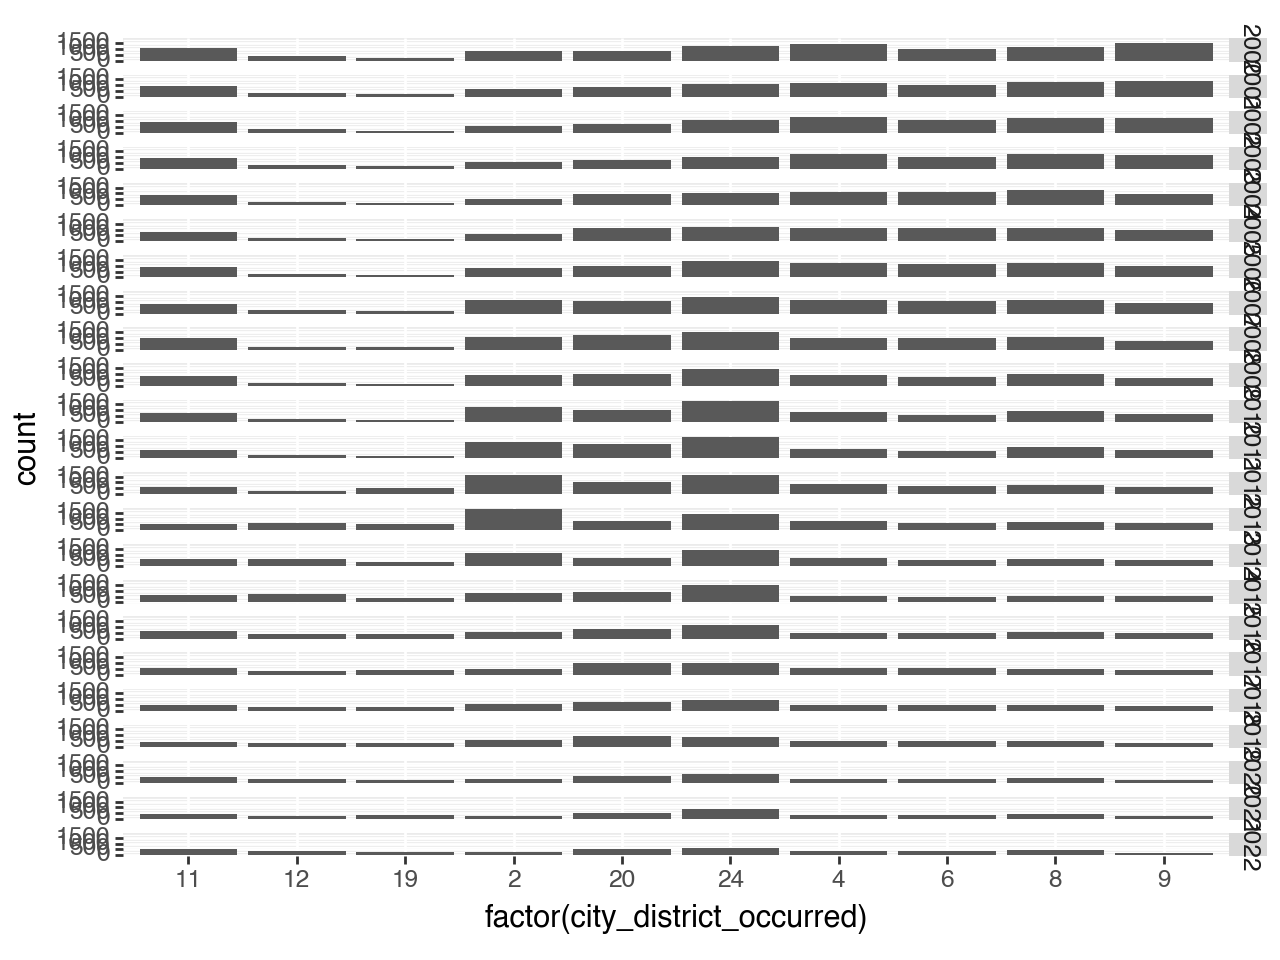

<Figure Size: (640 x 480)>

In [7]:
(ggplot(df, aes('factor(city_district_occurred)', 'count'))
 + geom_col()
 + facet_grid('year_occurred ~ .')
)

## `year_occurred`

In [8]:
mp[['rd_no', 'year_occurred', 'city_district_occurred']]

,rd_no,year_occurred,city_district_occurred
0,F012033,2000,3
1,F021758,2000,14
2,F094577,2000,14
3,F121480,2000,13
4,F118317,2000,2
...,...,...,...
301,HW137496,2013,None
305,HW220644,2013,None
310,HW278331,2013,None
318,HW530680,2013,None


In [9]:
df = pd.DataFrame(mp[['year_occurred', 'city_district_occurred']].value_counts()).reset_index()
sample_df = df.loc[df.city_district_occurred.isin(sample_districts)].copy()
df

,year_occurred,city_district_occurred,count
0,2010,24,1806
1,2011,24,1792
2,2013,2,1780
3,2012,2,1644
4,2012,24,1610
...,...,...,...
540,2011,1,68
541,2000,1,64
542,2007,1,62
543,2001,1,43


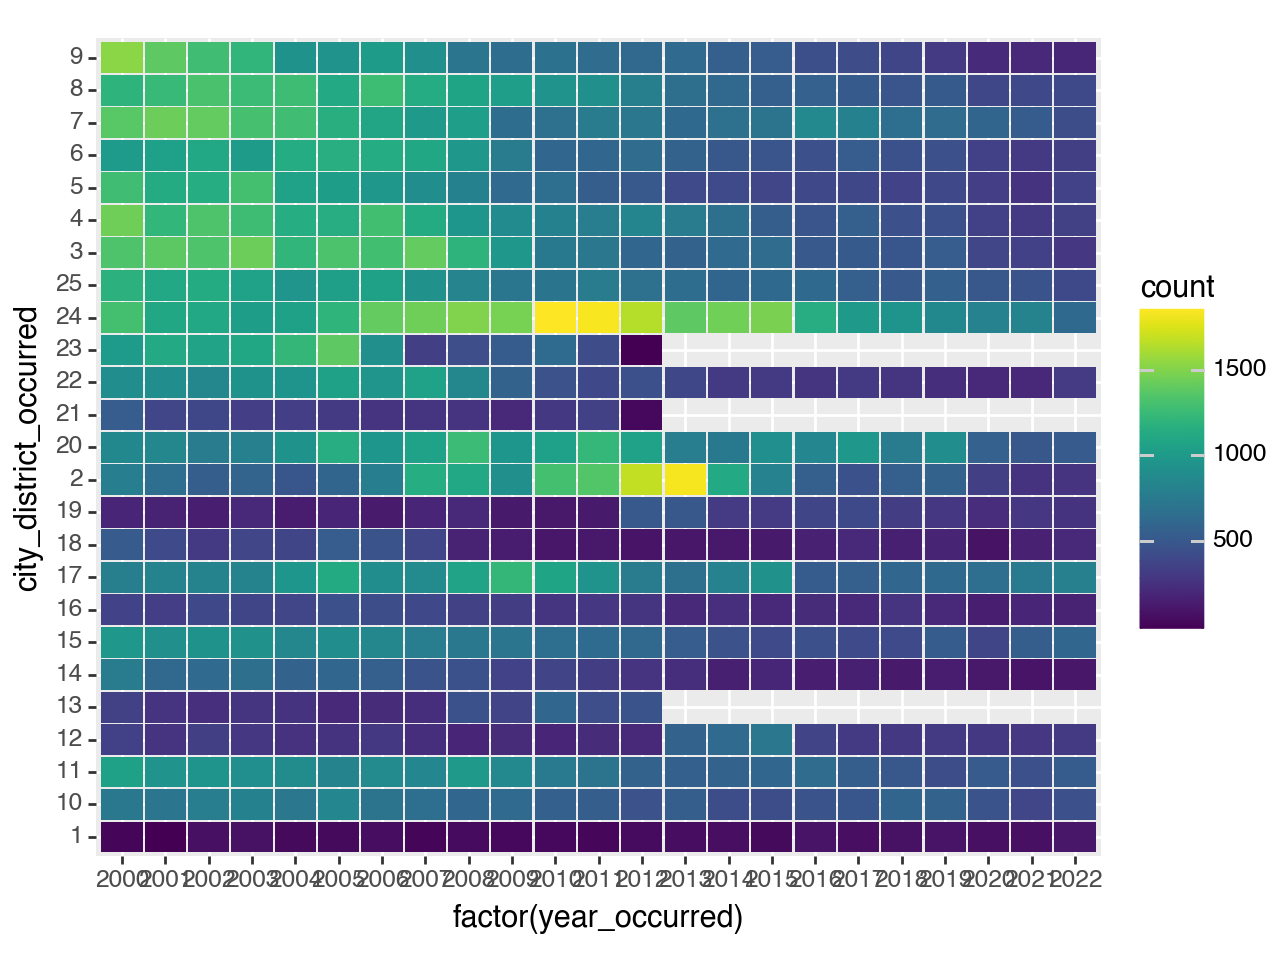

<Figure Size: (640 x 480)>

In [10]:
(ggplot(df, aes('factor(year_occurred)', 'city_district_occurred', fill='count'))
 + geom_tile(aes(width=.95, height=.95))
)

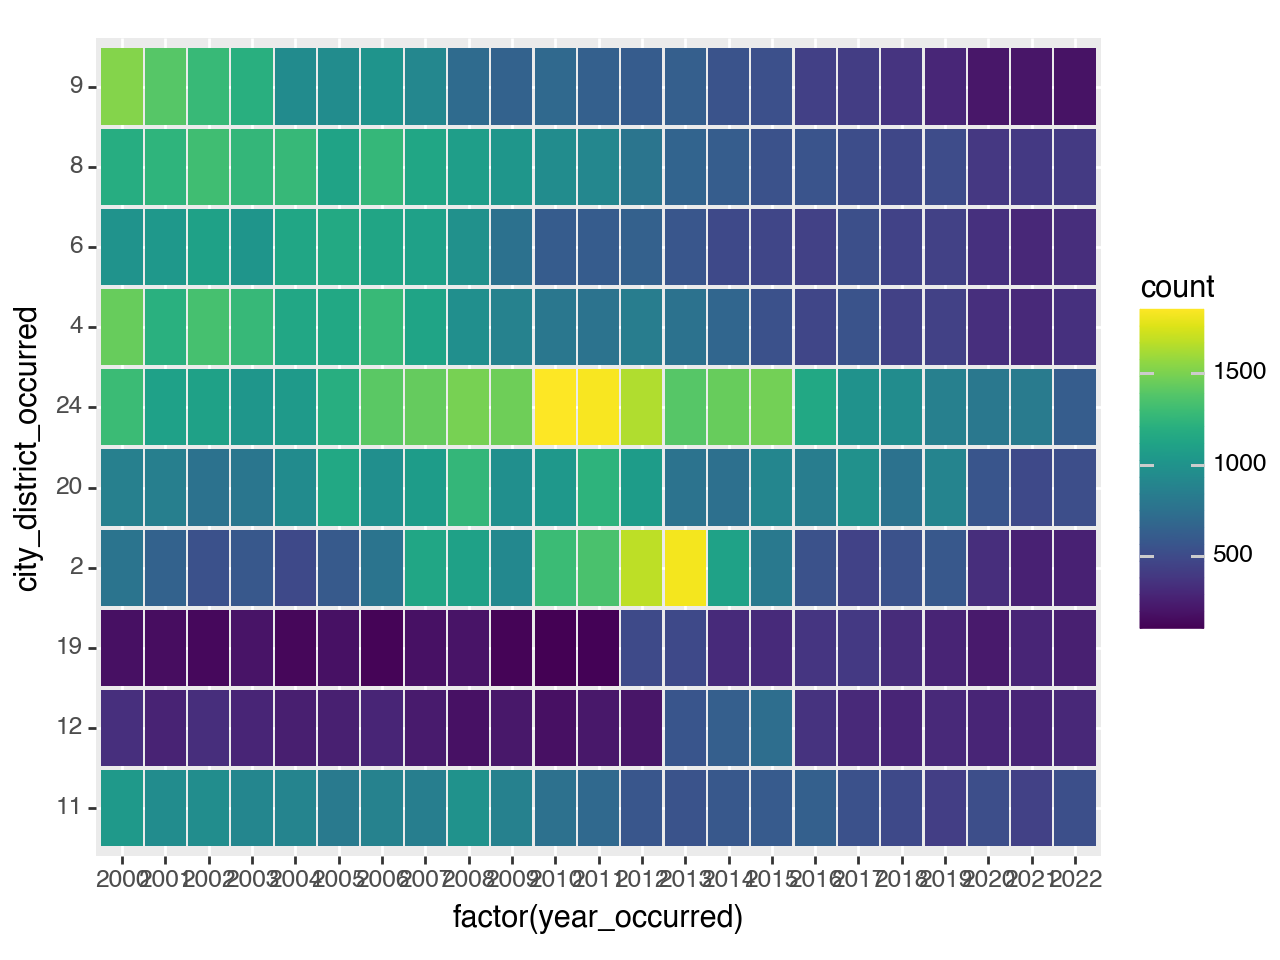

<Figure Size: (640 x 480)>

In [11]:
(ggplot(sample_df, aes('factor(year_occurred)', 'city_district_occurred', fill='count'))
 + geom_tile(aes(width=.95, height=.95))
)

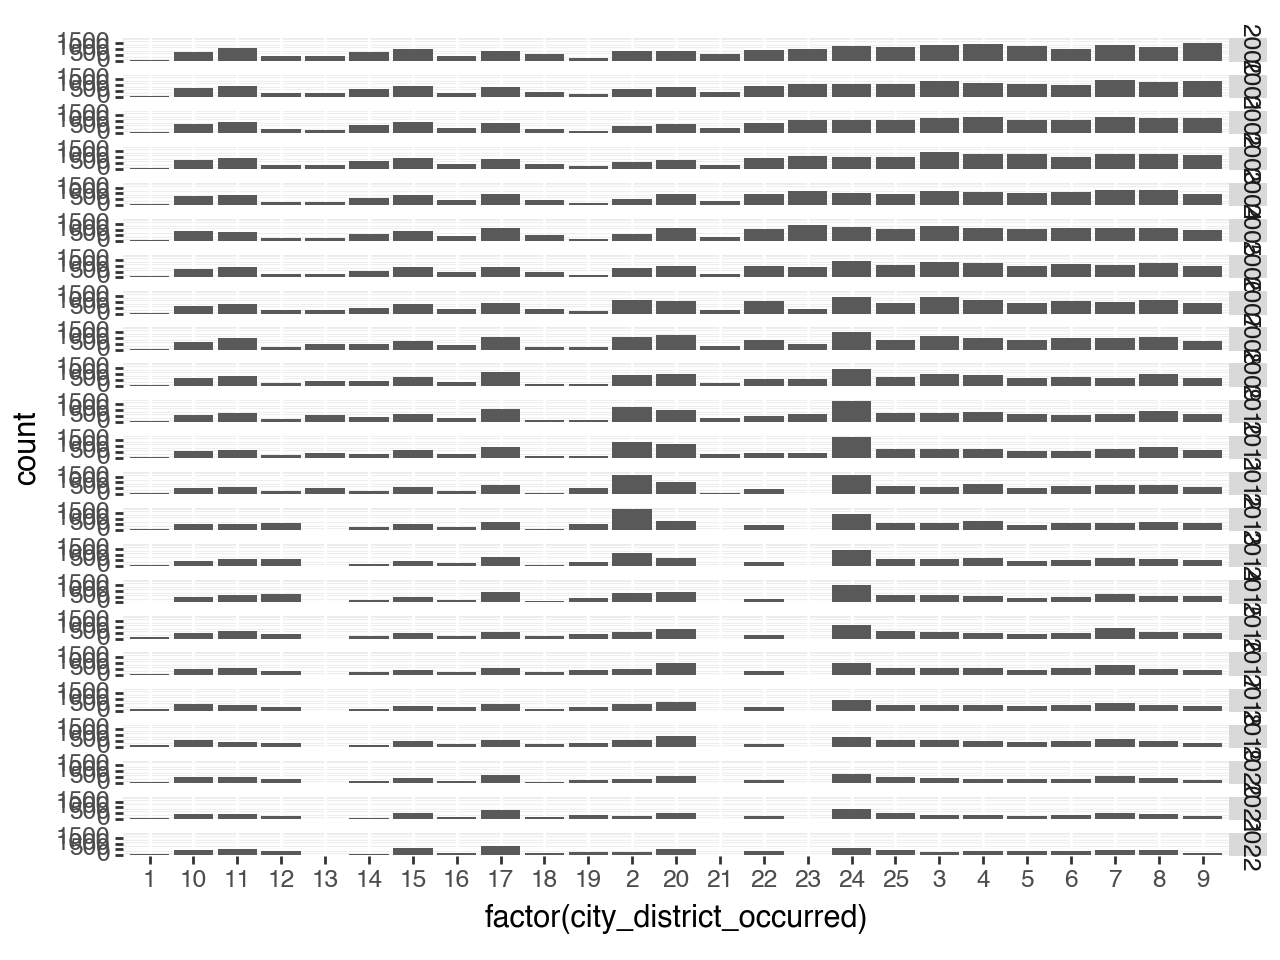

<Figure Size: (640 x 480)>

In [12]:
(ggplot(df, aes('factor(city_district_occurred)', 'count'))
 + geom_col()
 + facet_grid('year_occurred ~ .')
)

*****why are there `None`s*****

In [13]:
no_dist_oad = mp.loc[(mp.city_district_occurred.isna()) & (mp.tta_group == 'MISSING'), 'rd_no'].unique()
mp.loc[mp.rd_no.isin(no_dist_oad), ['rd_no', 'race', 'sex', 'age_group']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 270 entries, 4617 to 352824
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rd_no      270 non-null    object
 1   race       268 non-null    object
 2   sex        268 non-null    object
 3   age_group  269 non-null    object
dtypes: object(4)
memory usage: 10.5+ KB


- maybe outside jurisdiction?

In [14]:
mp.loc[mp.rd_no.isin(no_dist_oad), ['beat_occurred', 'beat_assigned']] # what is the issue here?

,beat_occurred,beat_assigned
4617,NaN,1102
4717,NaN,1524
6185,NaN,0121
7477,NaN,9172
8576,NaN,1135
...,...,...
351644,NaN,9154
351774,NaN,2513
351977,NaN,2402
351980,NaN,1831


## missing officer timestamps
- `time_to_arrive`
- `time_to_notify`
- `time_to_close`

In [15]:
df = mp[['year_occurred', 'city_district_occurred',
         'date_officer_arrived', 'notification_time', 'closed_date',
         'tta_group', 'ttn_group', 'ttc_group']].copy()
df['arrival_reported'] = df.date_officer_arrived.notna()
df['notification_reported'] = df.notification_time.notna()
df['closure_reported'] = df.closed_date.notna()
df['count'] = 1
df

,year_occurred,city_district_occurred,date_officer_arrived,notification_time,closed_date,tta_group,ttn_group,ttc_group,arrival_reported,notification_reported,closure_reported,count
0,2000,3,2000-01-06 18:55:00,2000-01-06 20:16:00,2000-01-15,more than 120 min,under 12 hours,under 14 days,True,True,True,1
1,2000,14,2000-01-11 13:40:00,2000-01-11 14:27:00,2000-01-16,more than 120 min,under 1 hour,under 7 days,True,True,True,1
2,2000,14,2000-02-16 12:00:00,NaT,2000-03-08,more than 120 min,MISSING,under 30 days,True,False,True,1
3,2000,13,2000-02-29 13:40:00,2000-02-29 16:45:00,2000-03-17,more than 120 min,under 12 hours,under 30 days,True,True,True,1
4,2000,2,2000-02-28 00:45:00,2000-02-28 02:27:00,2000-03-24,more than 120 min,under 12 hours,under 30 days,True,True,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...
301,2013,None,NaT,NaT,NaT,None,None,None,False,False,False,1
305,2013,None,NaT,NaT,NaT,None,None,None,False,False,False,1
310,2013,None,NaT,NaT,NaT,None,None,None,False,False,False,1
318,2013,None,NaT,NaT,NaT,None,None,None,False,False,False,1


In [20]:
report_rates = df[['year_occurred', 'city_district_occurred', 
                   'arrival_reported', 'notification_reported', 'closure_reported', 
                   'count']].groupby(
    ['year_occurred', 'city_district_occurred']).sum().reset_index()

In [23]:
report_rates.loc[report_rates.year_occurred > 2020, 
                 ['year_occurred', 'city_district_occurred', 'closure_reported']]

,year_occurred,city_district_occurred,closure_reported
501,2021,1,0
502,2021,10,0
503,2021,11,0
504,2021,12,0
505,2021,14,0
506,2021,15,0
507,2021,16,0
508,2021,17,0
509,2021,18,0
510,2021,19,0


In [16]:
report_rates = df[['year_occurred', 'city_district_occurred', 
                   'arrival_reported', 'notification_reported', 'closure_reported', 
                   'count']].groupby(
    ['year_occurred', 'city_district_occurred']).sum().reset_index()
report_rates['arrival'] = report_rates.arrival_reported / report_rates['count']
report_rates['notification'] = report_rates.notification_reported / report_rates['count']
report_rates['closure'] = report_rates.closure_reported / report_rates['count']
report_rates = report_rates[['year_occurred', 
                             'city_district_occurred', 
                             'arrival', 
                             'notification', 
                             'closure']]
report_rates

,year_occurred,city_district_occurred,arrival,notification,closure
0,2000,1,0.968750,0.781250,1.0
1,2000,10,0.987952,0.874163,1.0
2,2000,11,0.988450,0.869105,1.0
3,2000,12,0.989305,0.868984,1.0
4,2000,13,0.997354,0.865079,1.0
...,...,...,...,...,...
540,2022,5,0.997396,0.992188,0.0
541,2022,6,0.991781,0.989041,0.0
542,2022,7,0.975281,0.991011,0.0
543,2022,8,0.971897,0.990632,0.0


In [16]:
report_rates_tidy = pd.melt(report_rates, 
                            id_vars=['year_occurred', 'city_district_occurred'],
                            value_vars=['arrival', 'notification', 'closure'], 
                            var_name='report_type', value_name='report_rate(%)')
report_rates_tidy

,year_occurred,city_district_occurred,report_type,report_rate(%)
0,2000,1,arrival,0.968750
1,2000,10,arrival,0.987952
2,2000,11,arrival,0.988450
3,2000,12,arrival,0.989305
4,2000,13,arrival,0.997354
...,...,...,...,...
1699,2023,5,closure,0.000000
1700,2023,6,closure,0.000000
1701,2023,7,closure,0.000000
1702,2023,8,closure,0.000000


### district 1

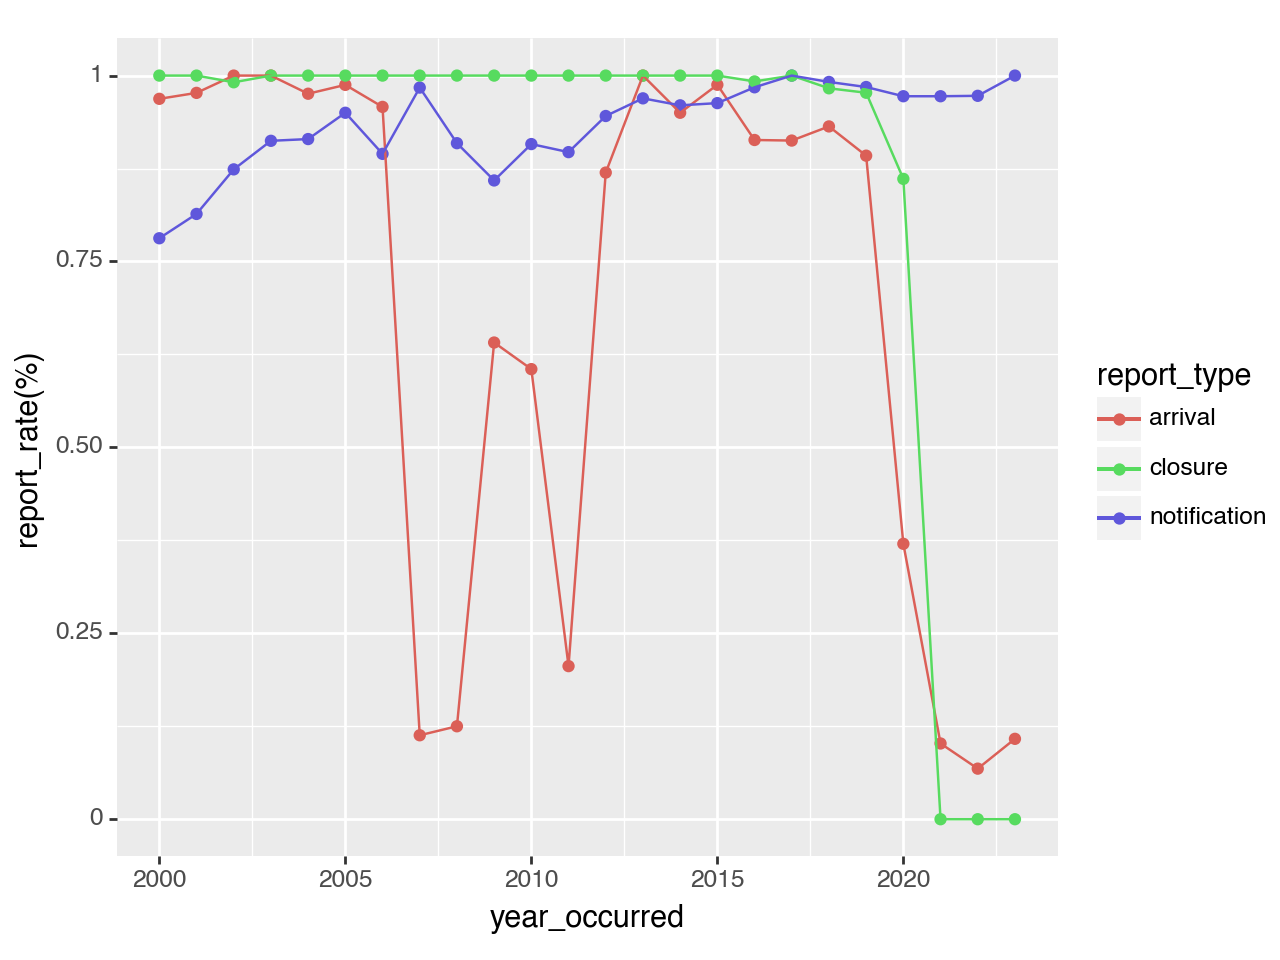

<Figure Size: (640 x 480)>

In [17]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '1', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

- For District 1, between roughly 2006 and 2012, officer arrival times were reported at a significantly lower rate than in periods leading up to (2000-2006) and following (2012-2019)

### district 2

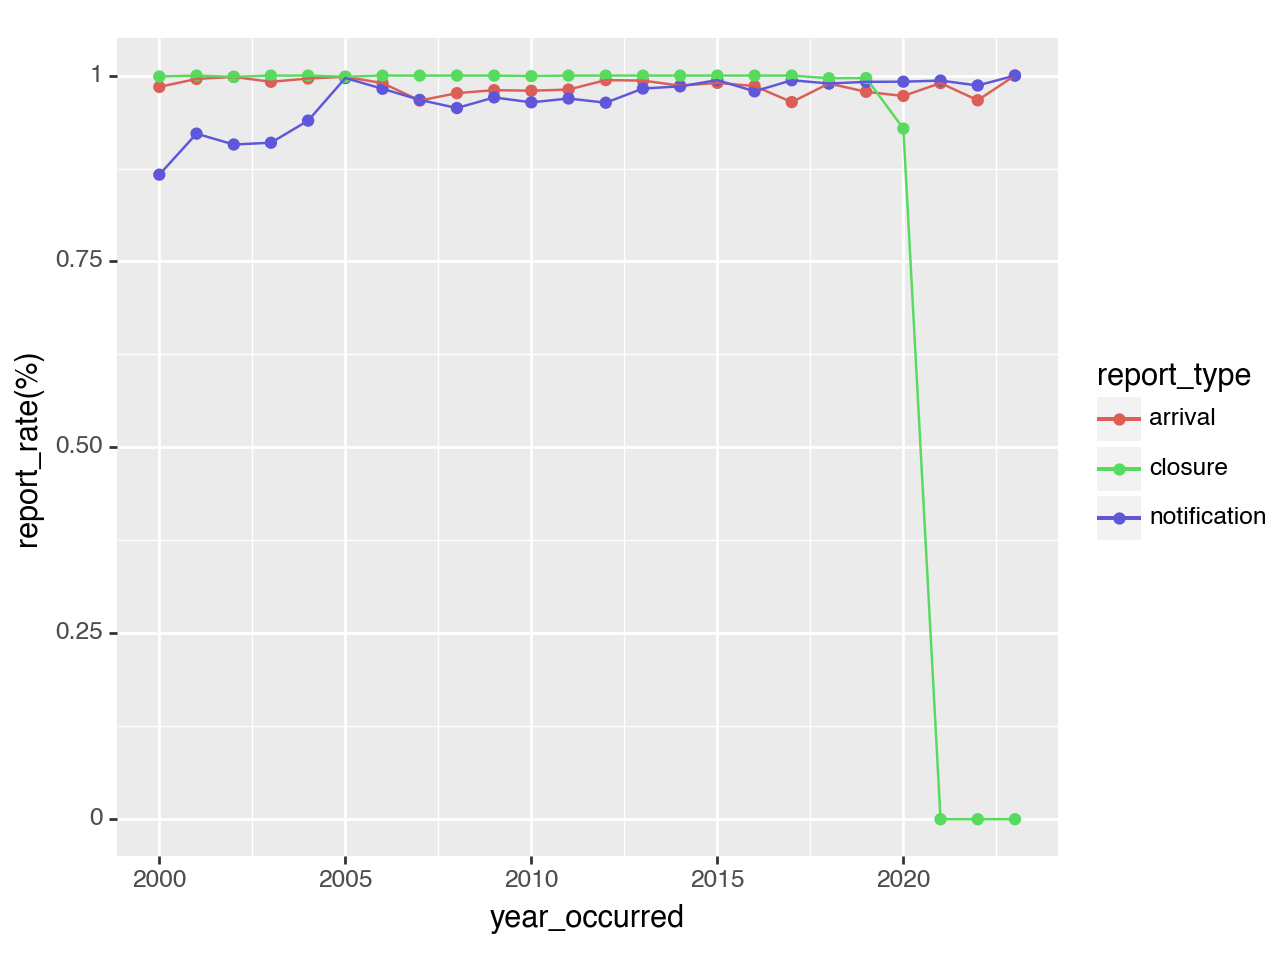

<Figure Size: (640 x 480)>

In [18]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '2', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 3

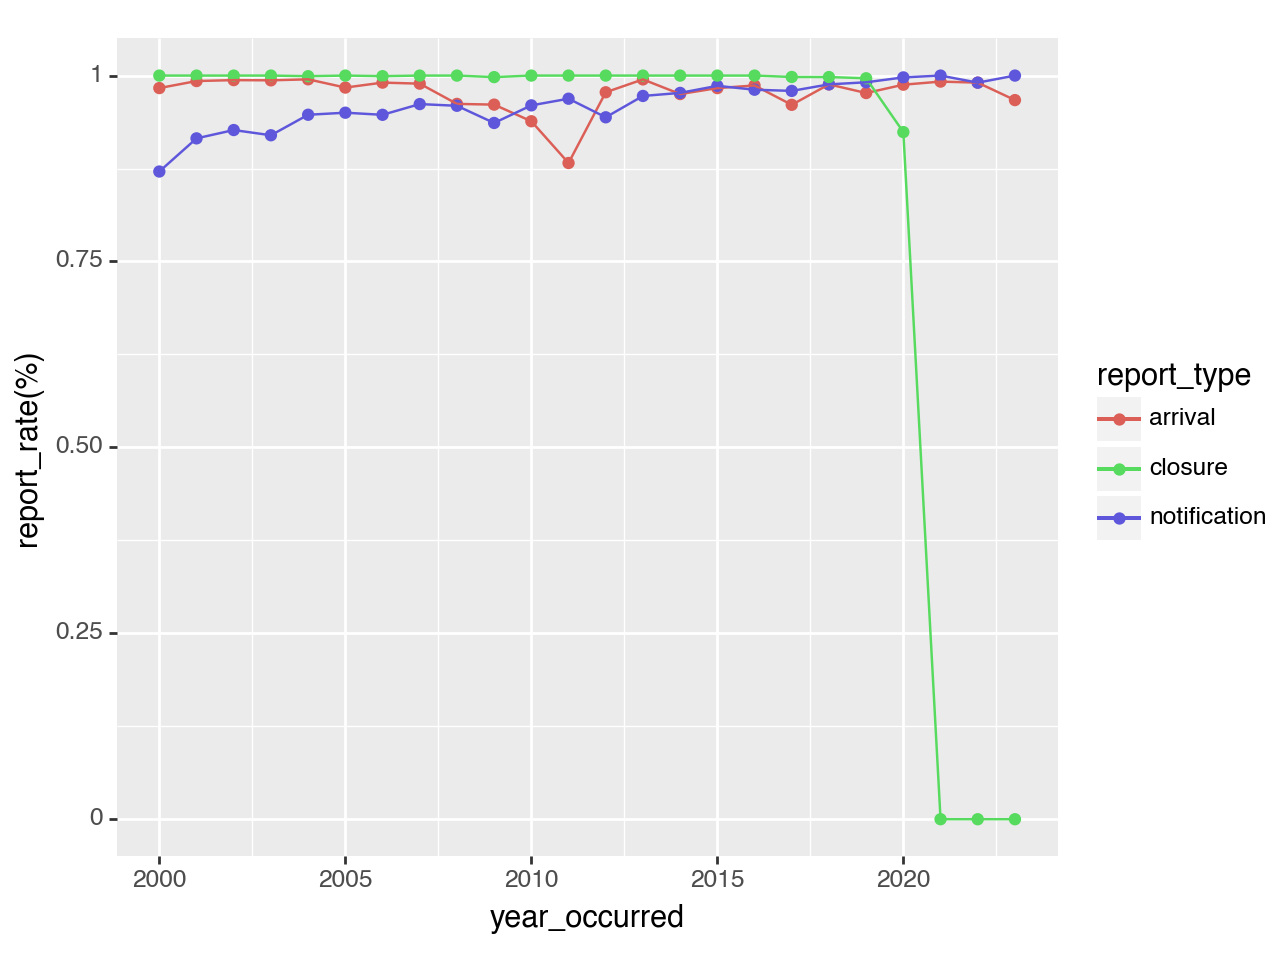

<Figure Size: (640 x 480)>

In [19]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '3', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 4

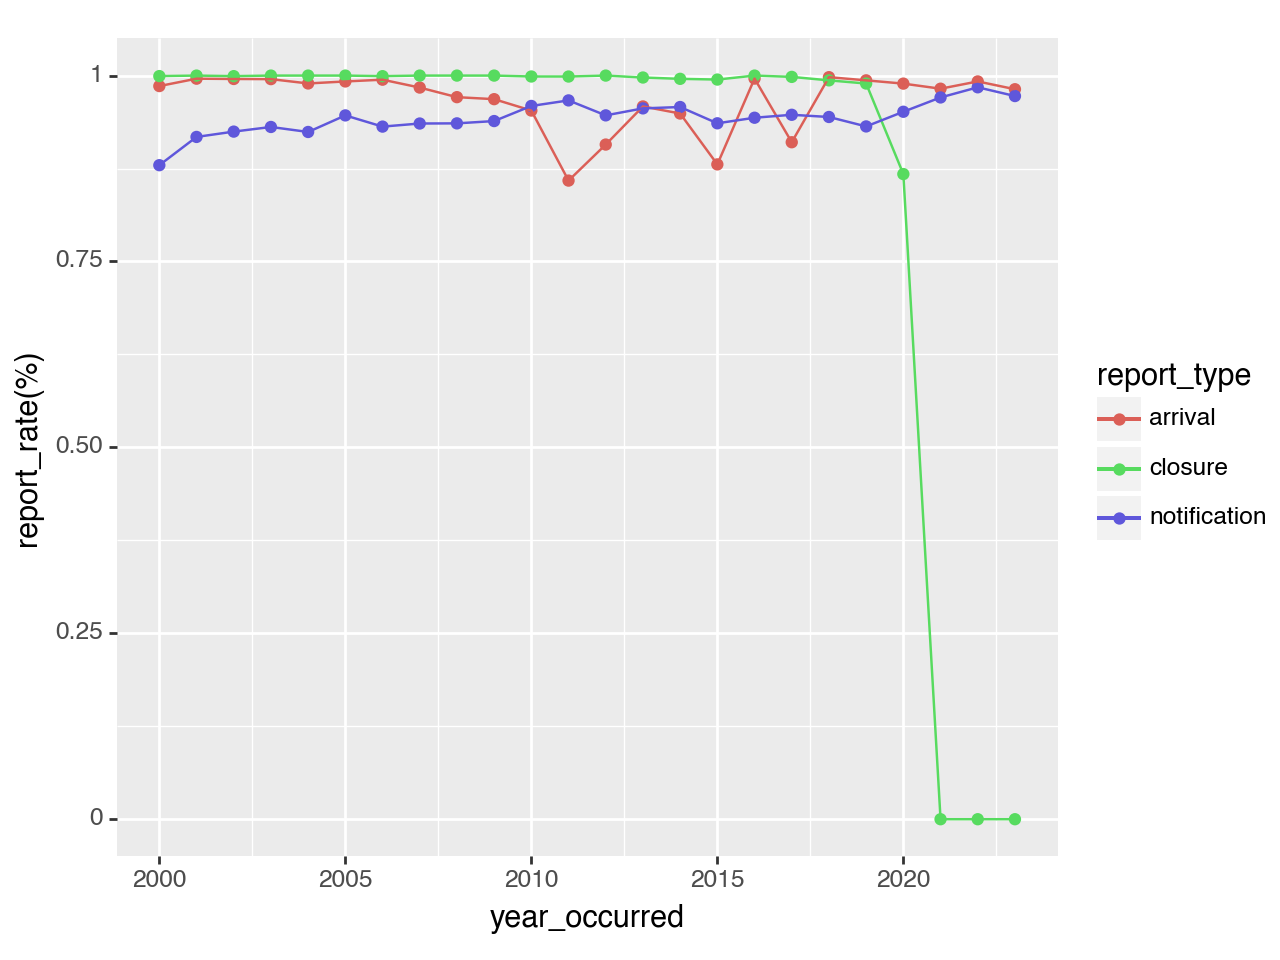

<Figure Size: (640 x 480)>

In [20]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '4', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 5

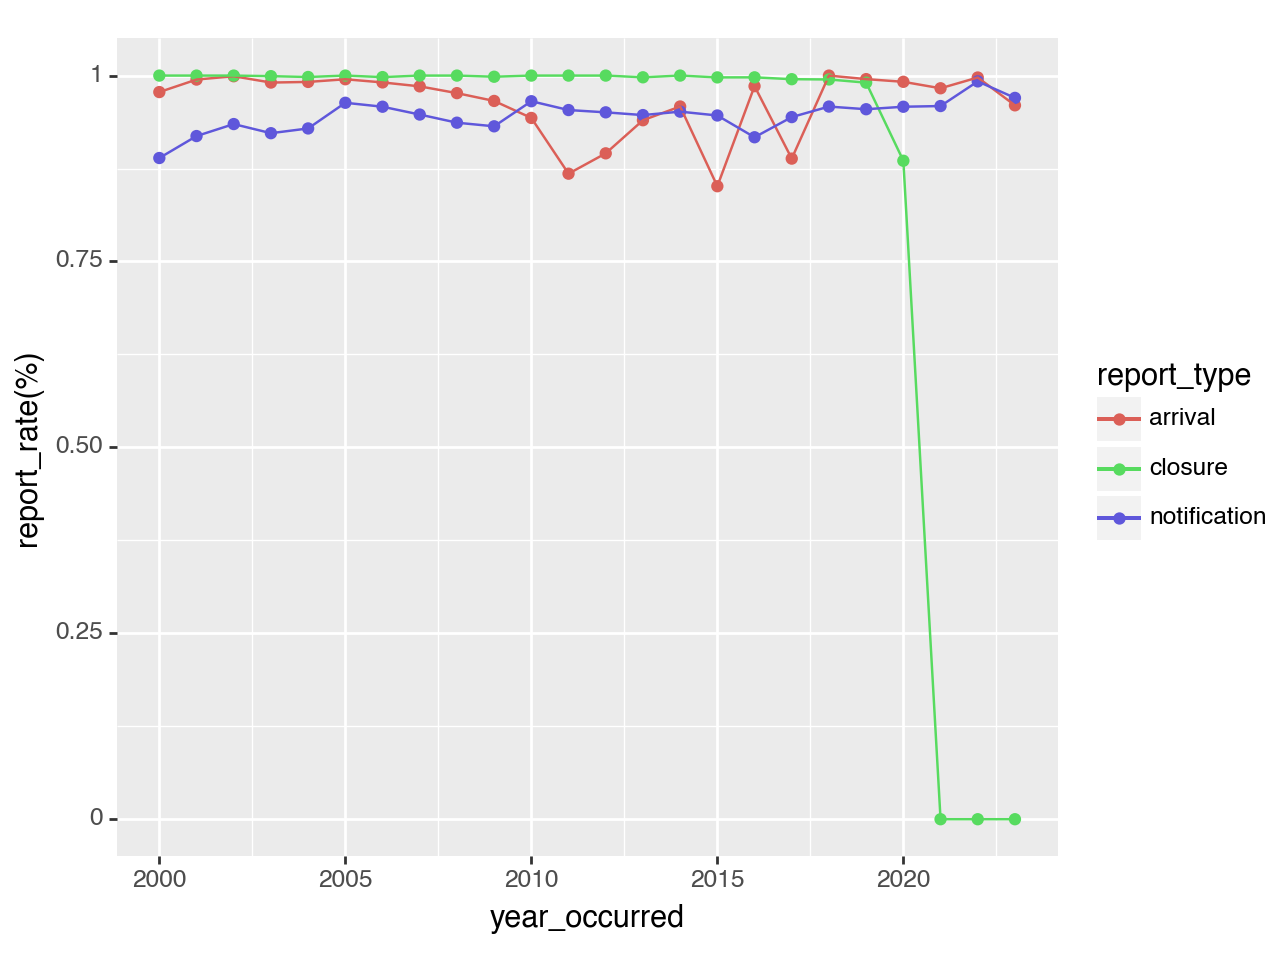

<Figure Size: (640 x 480)>

In [21]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '5', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 6

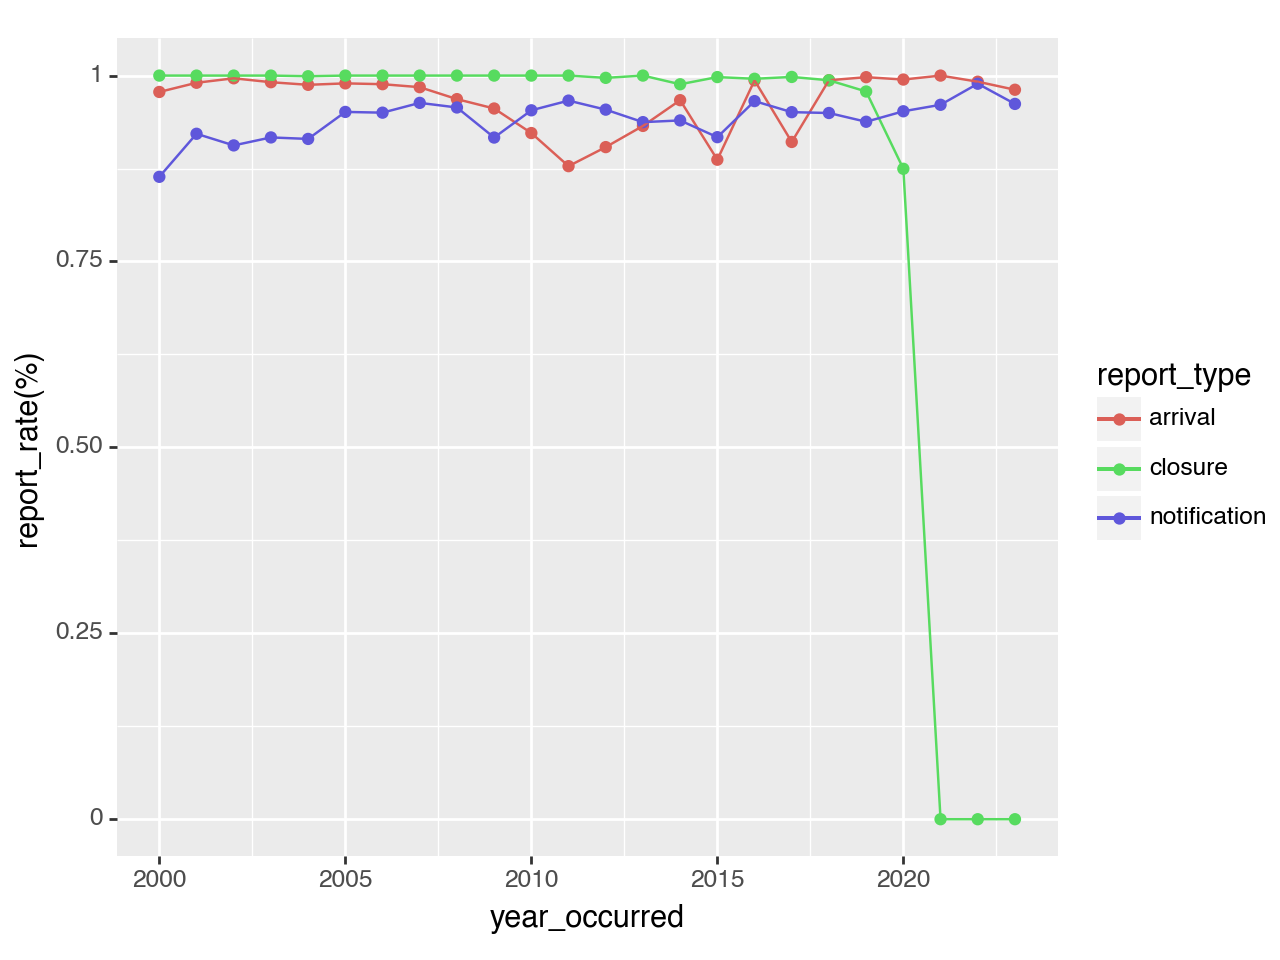

<Figure Size: (640 x 480)>

In [22]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '6', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 7

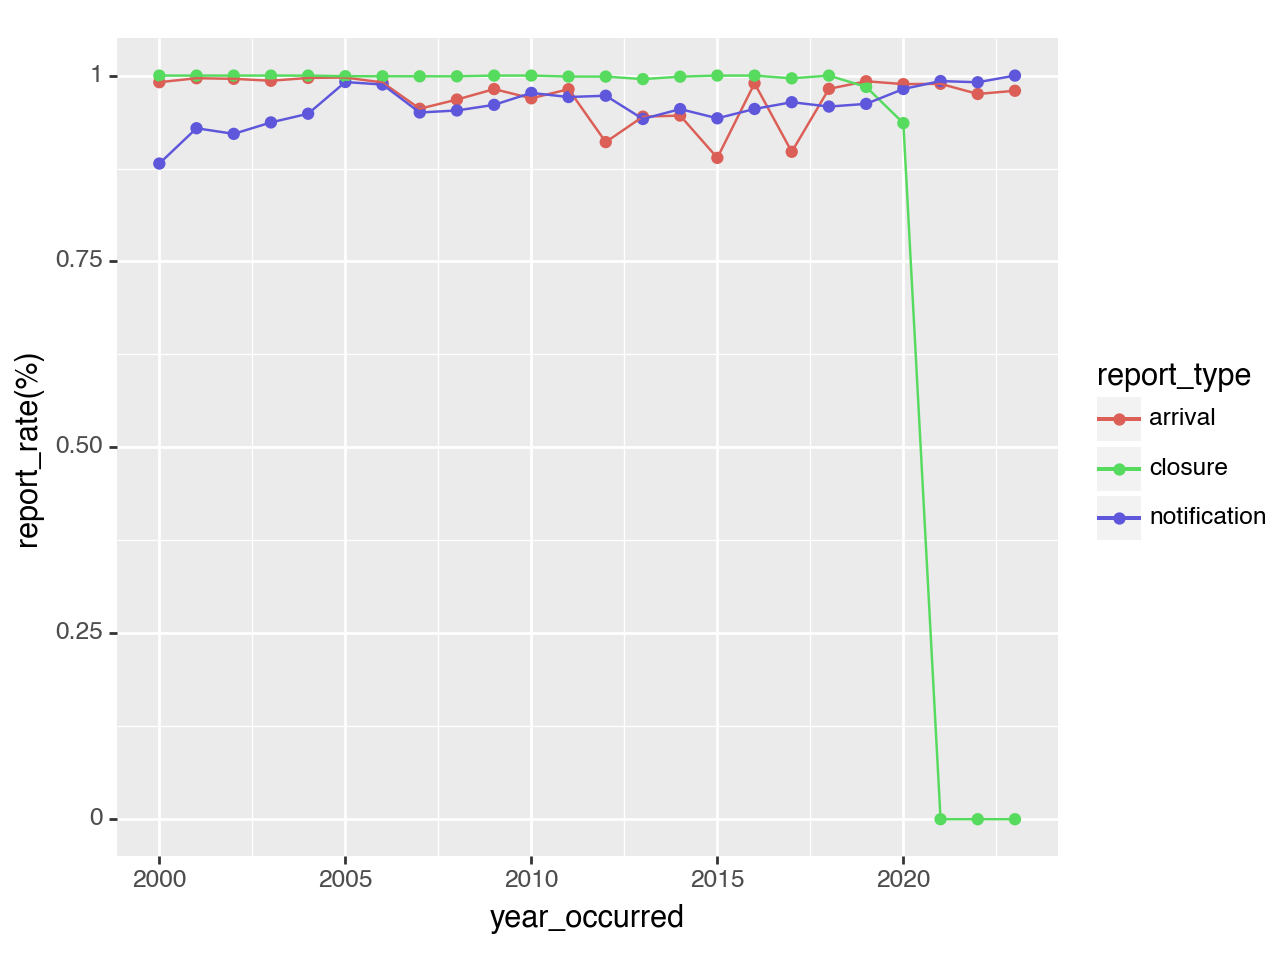

<Figure Size: (640 x 480)>

In [23]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '7', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 8

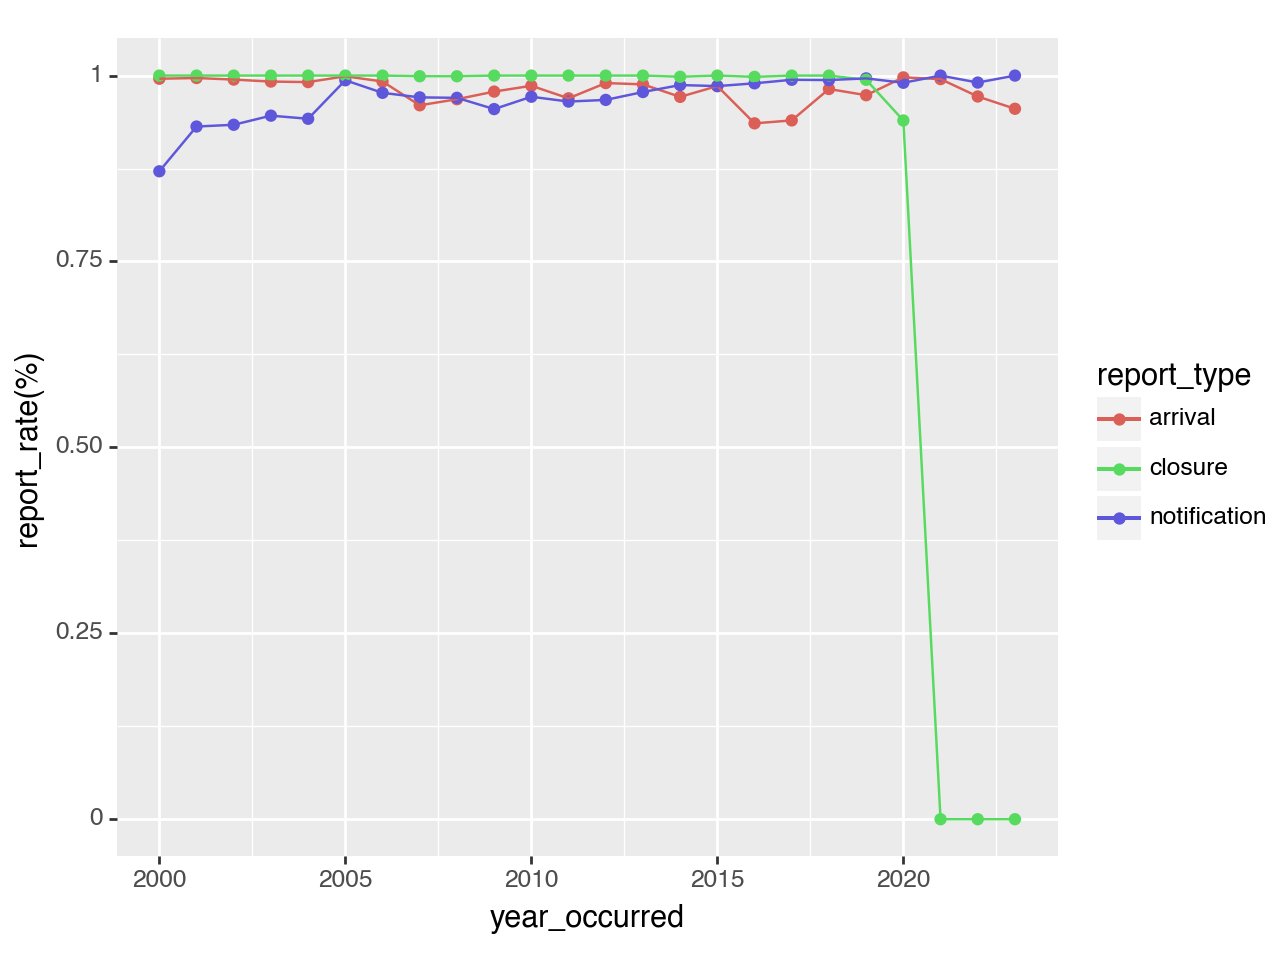

<Figure Size: (640 x 480)>

In [24]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '8', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 9

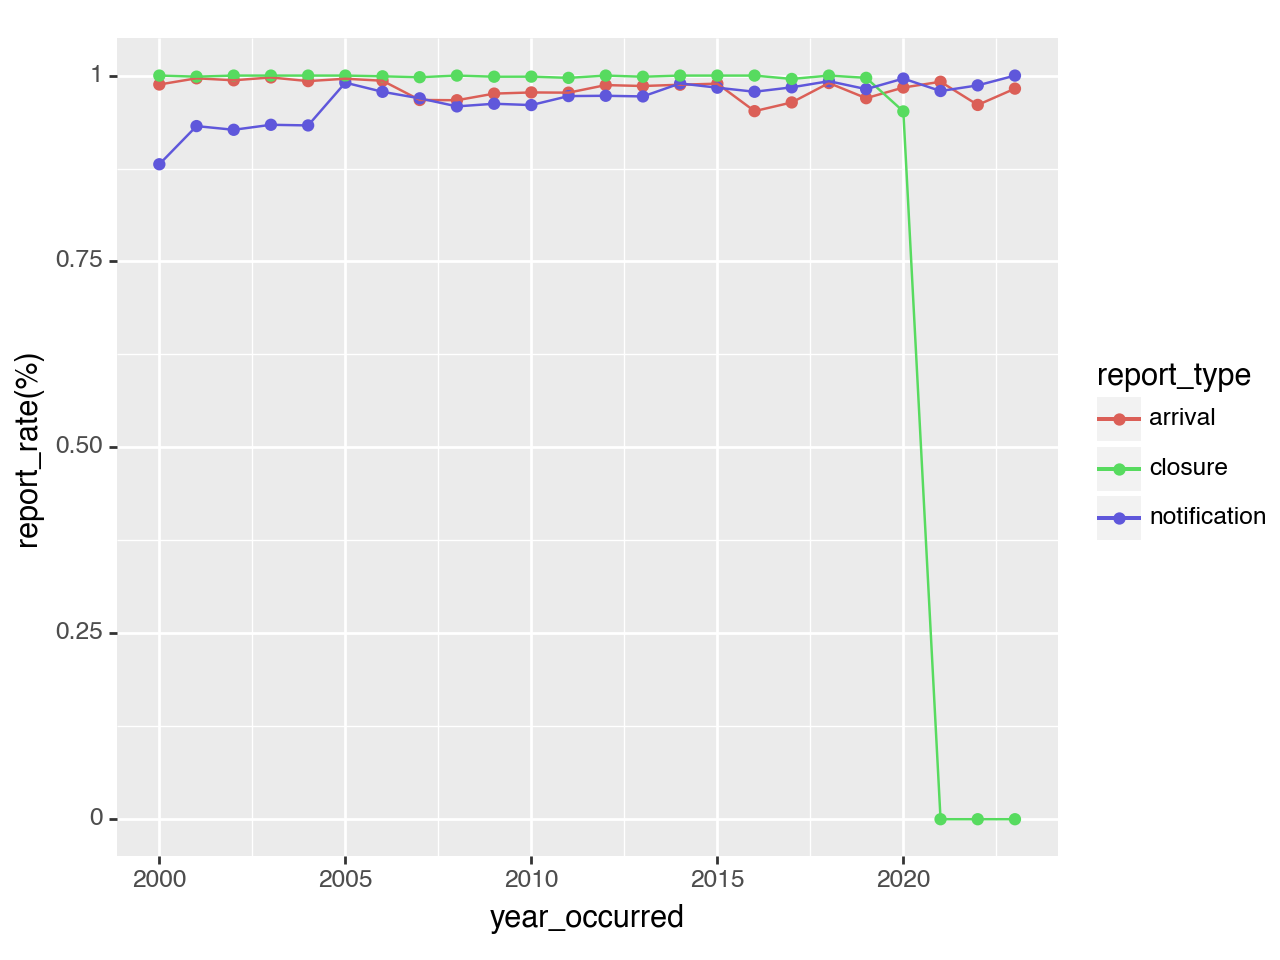

<Figure Size: (640 x 480)>

In [25]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '9', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 10

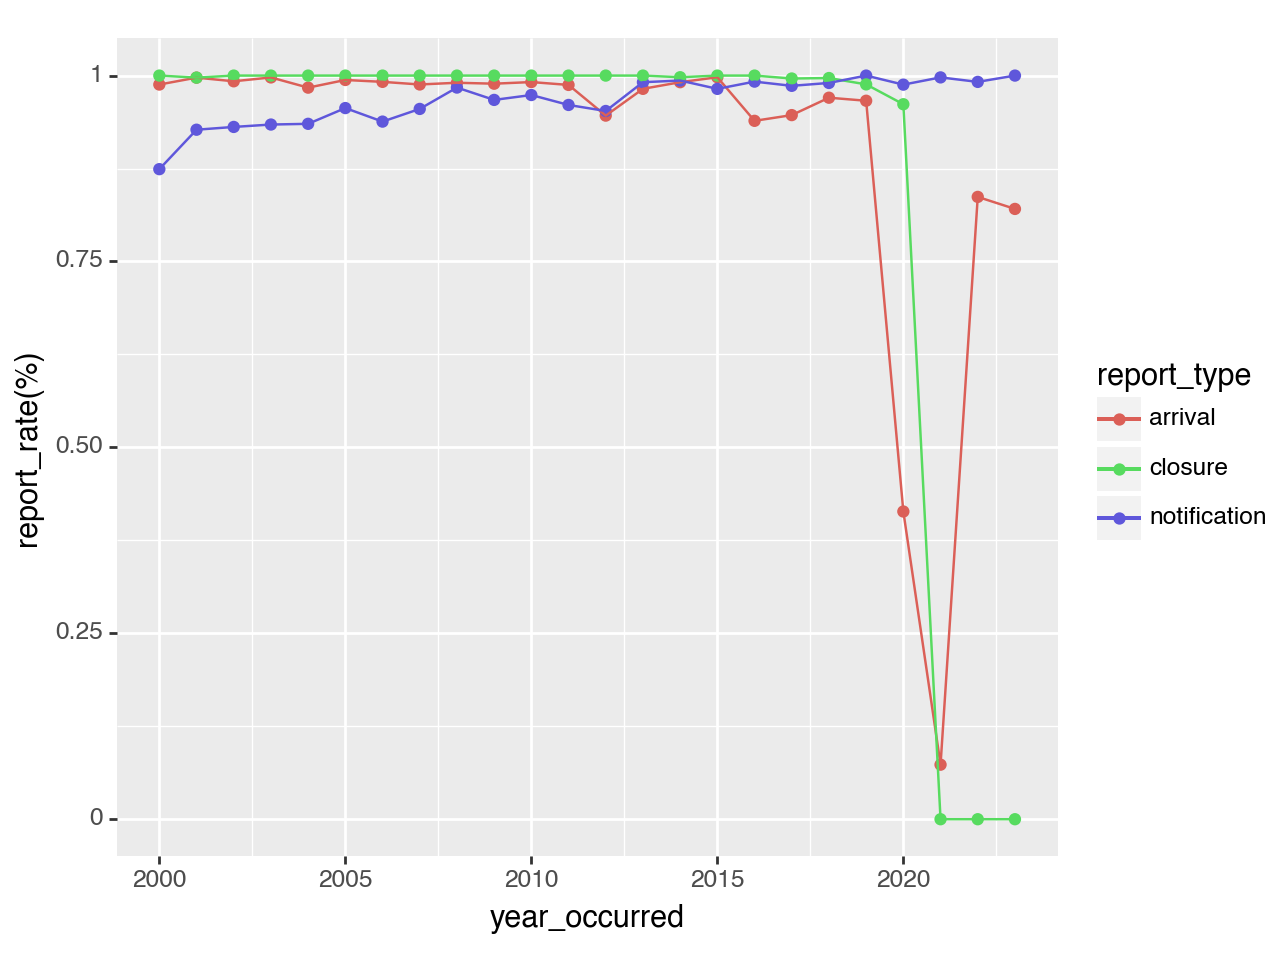

<Figure Size: (640 x 480)>

In [26]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '10', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 11

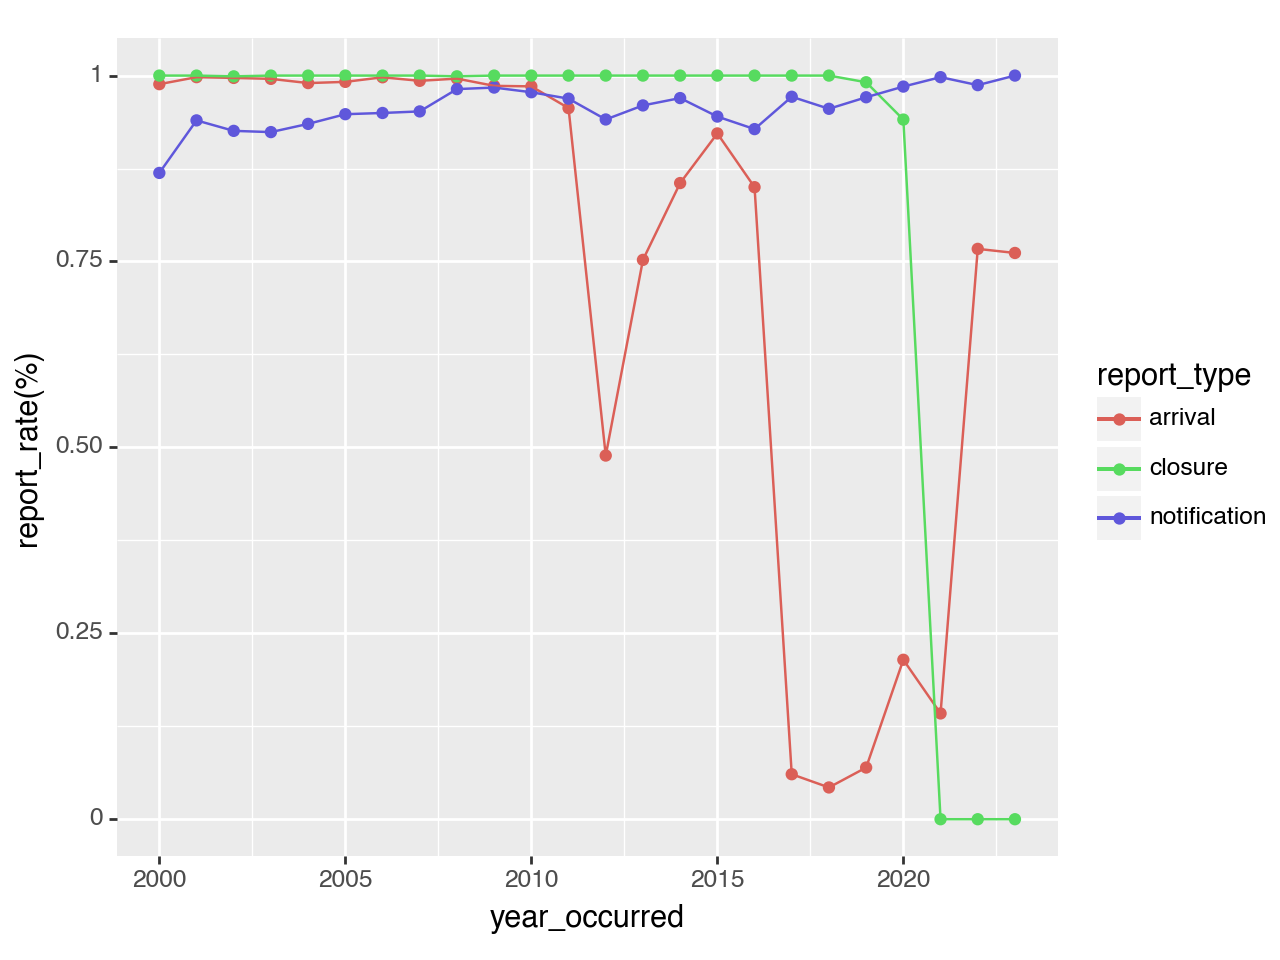

<Figure Size: (640 x 480)>

In [27]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '11', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 12

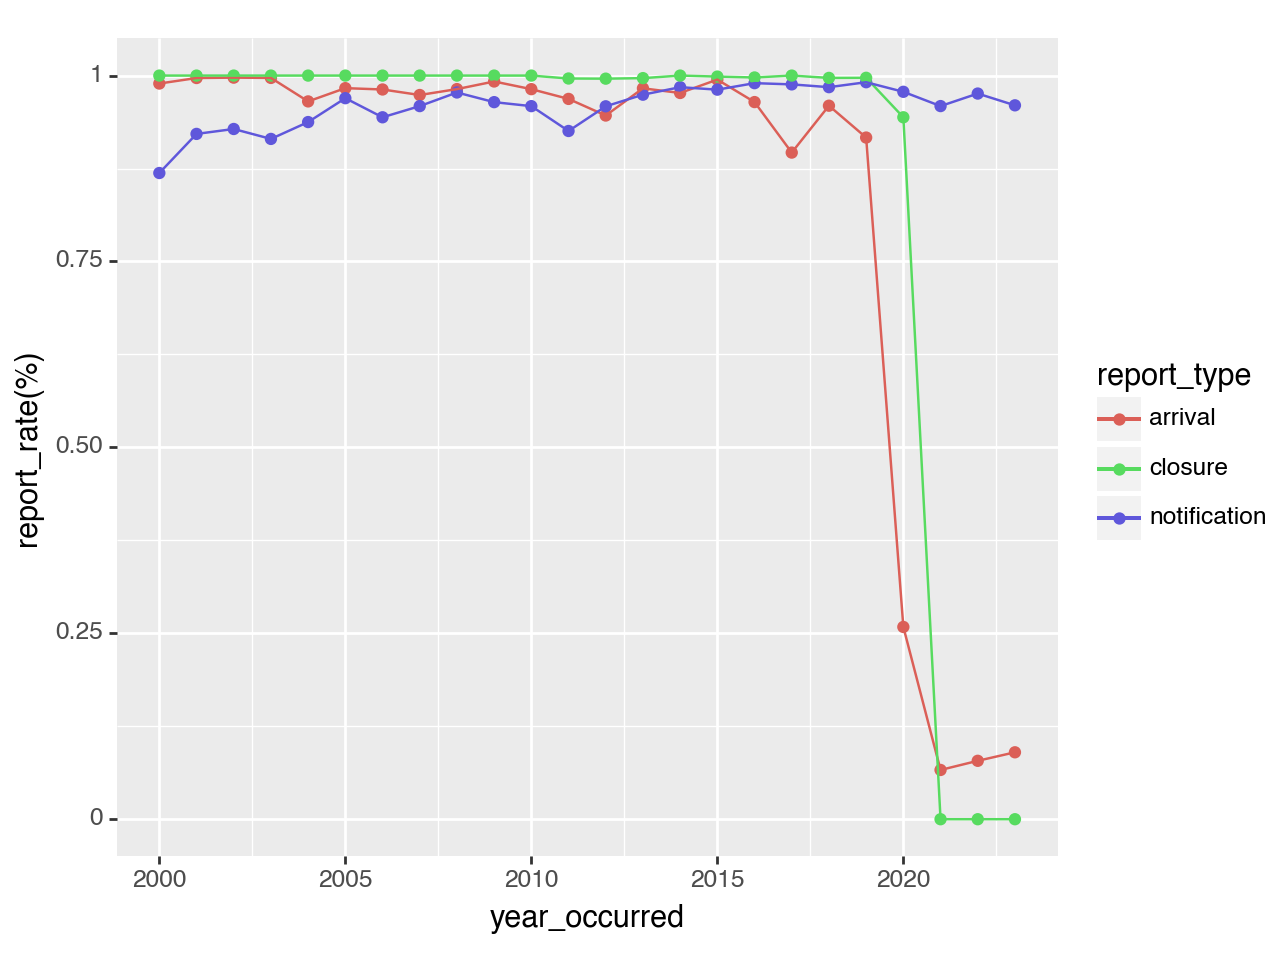

<Figure Size: (640 x 480)>

In [28]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '12', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 13

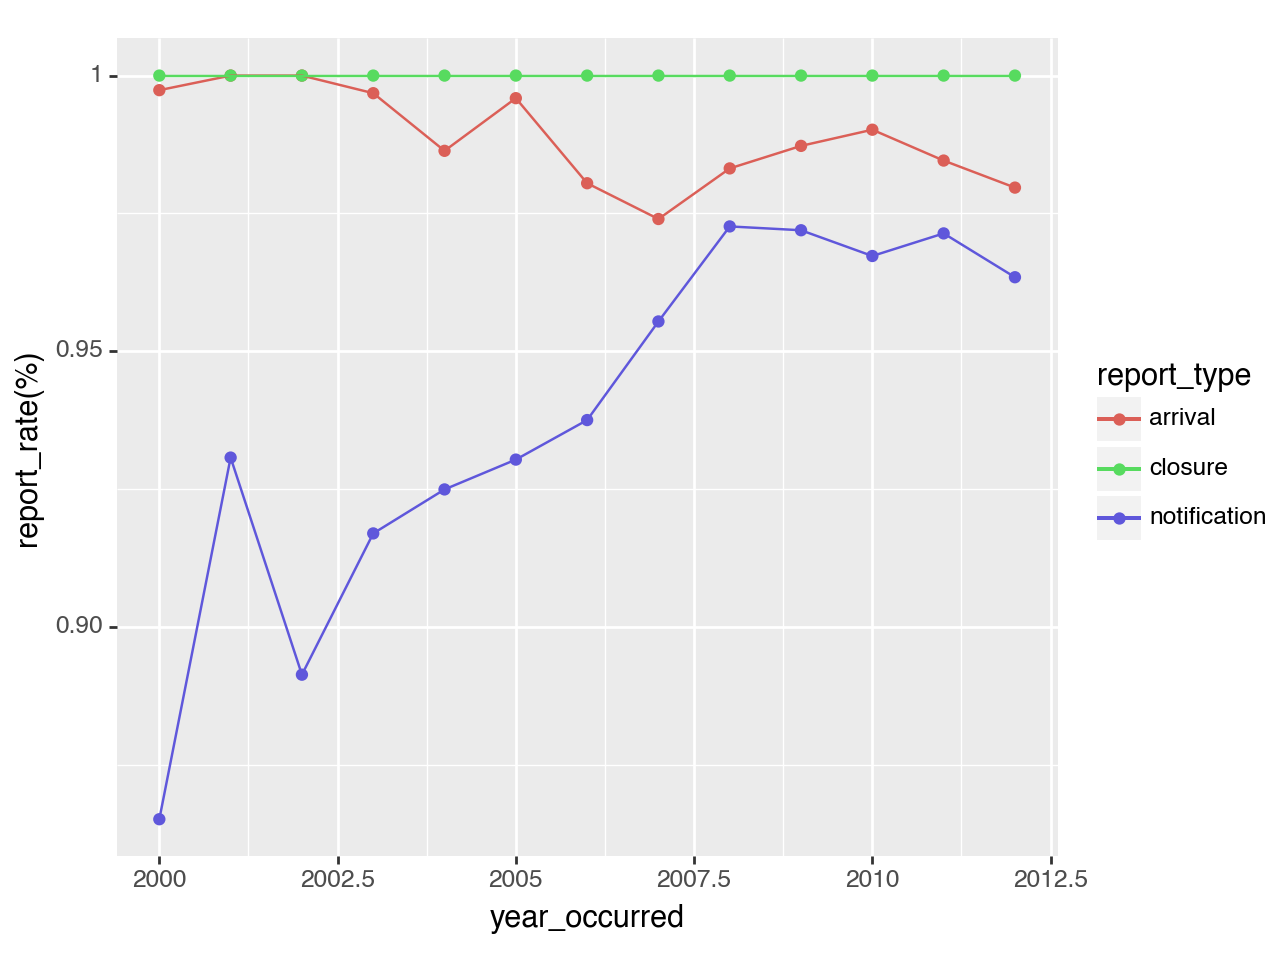

<Figure Size: (640 x 480)>

In [29]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '13', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 14

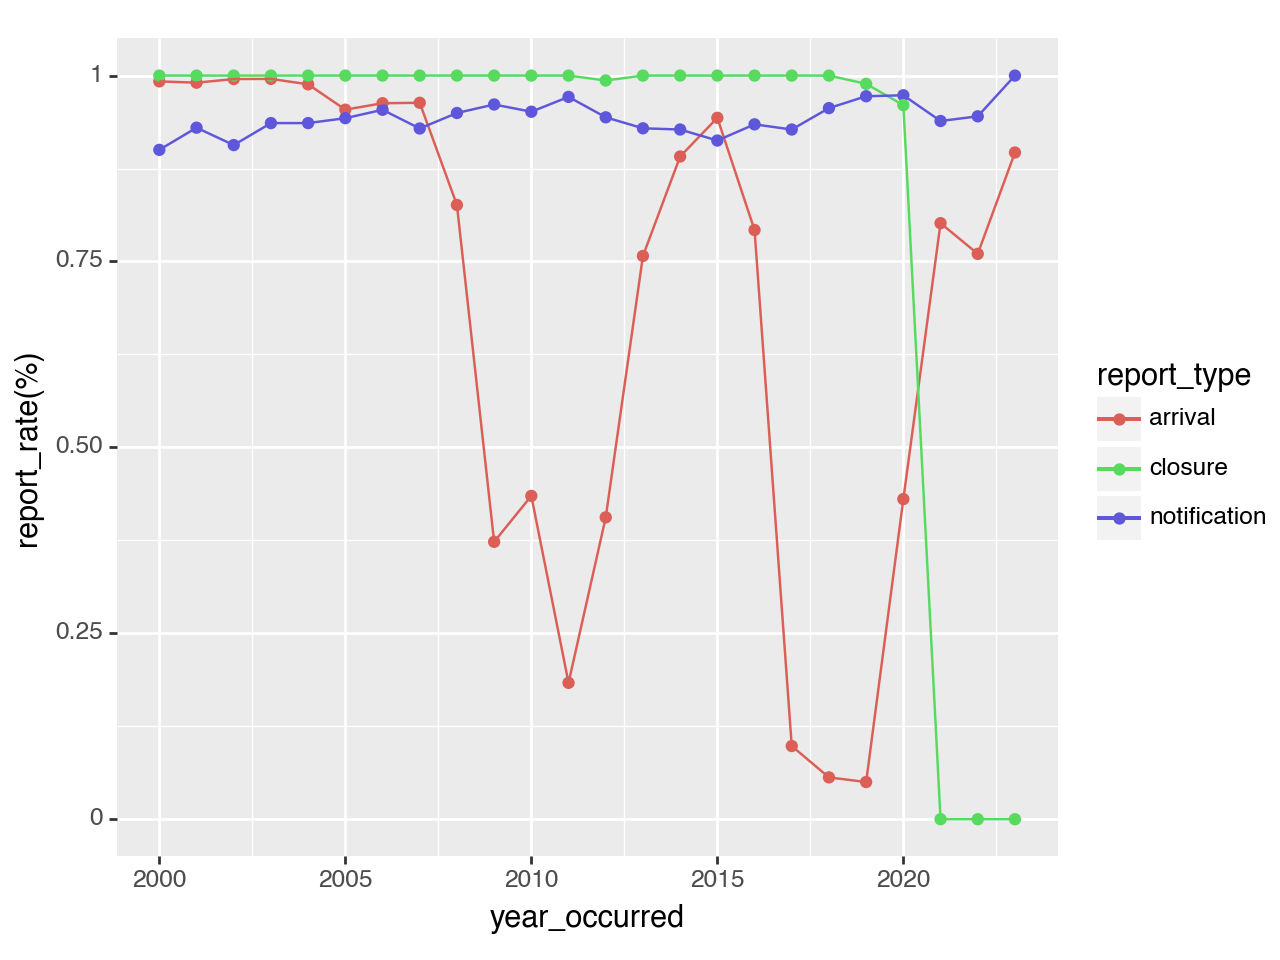

<Figure Size: (640 x 480)>

In [30]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '14', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 15

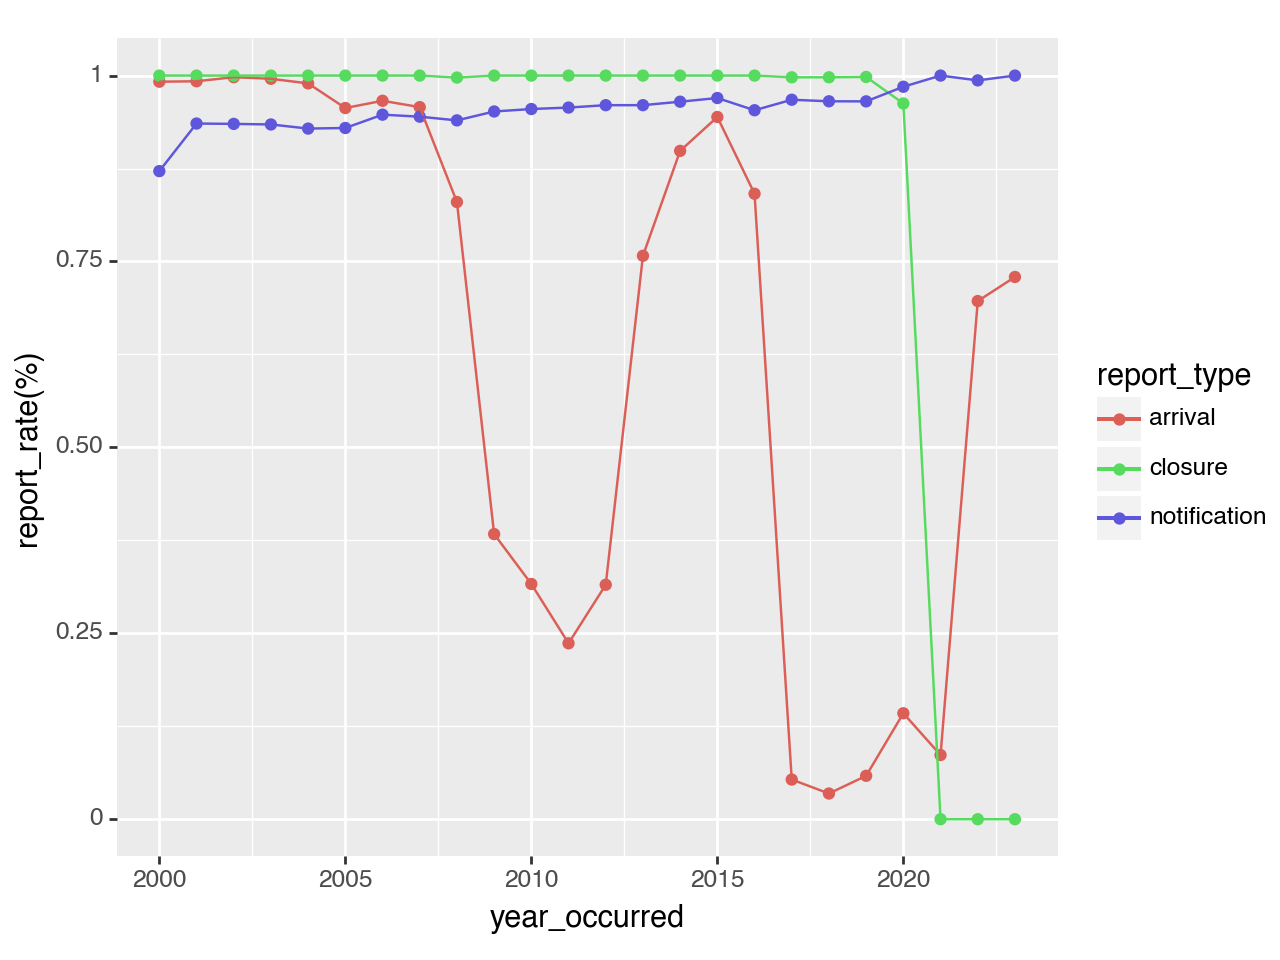

<Figure Size: (640 x 480)>

In [31]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '15', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 16

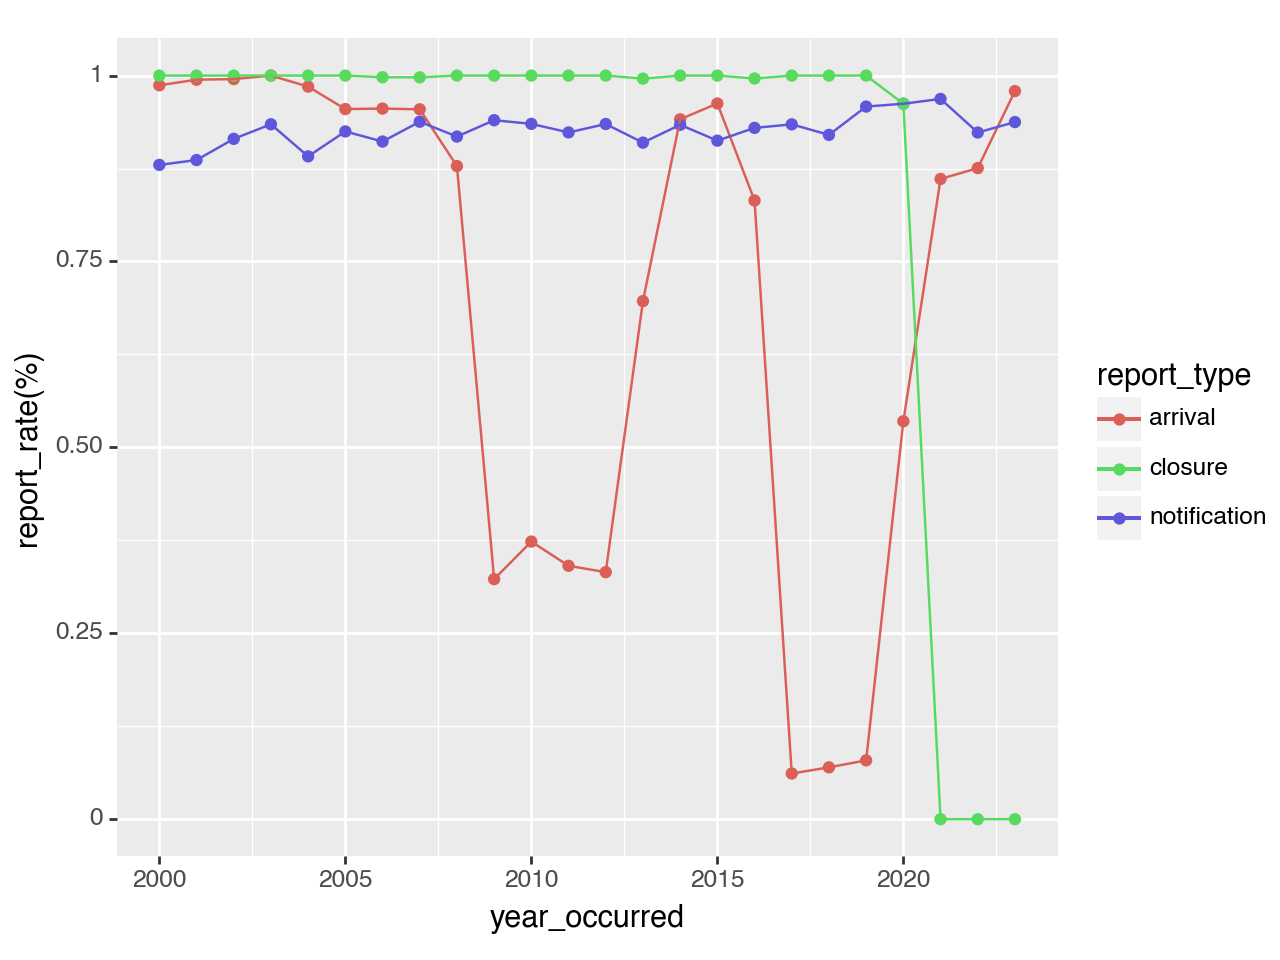

<Figure Size: (640 x 480)>

In [32]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '16', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 17

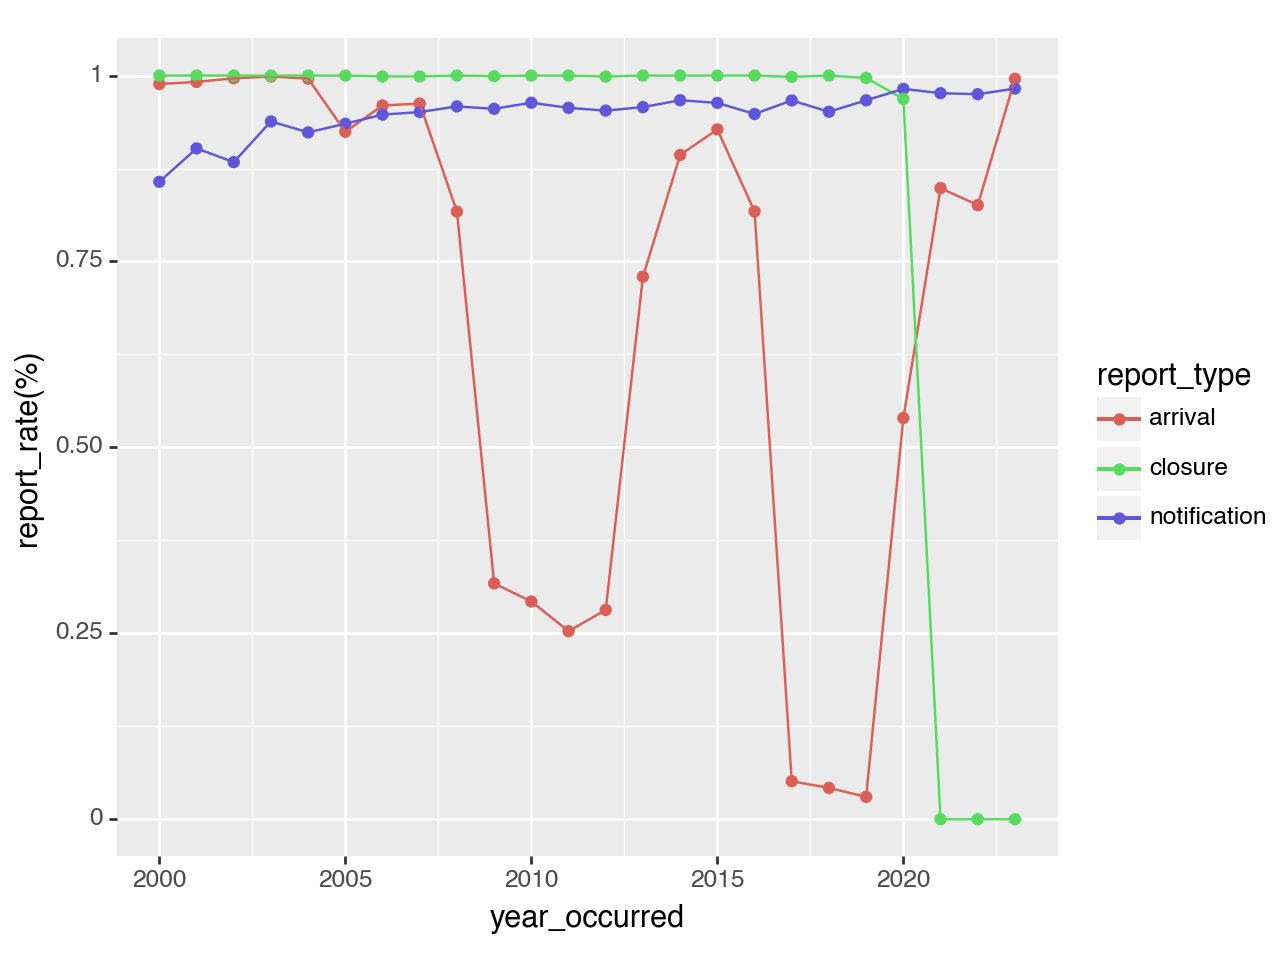

<Figure Size: (640 x 480)>

In [33]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '17', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 18

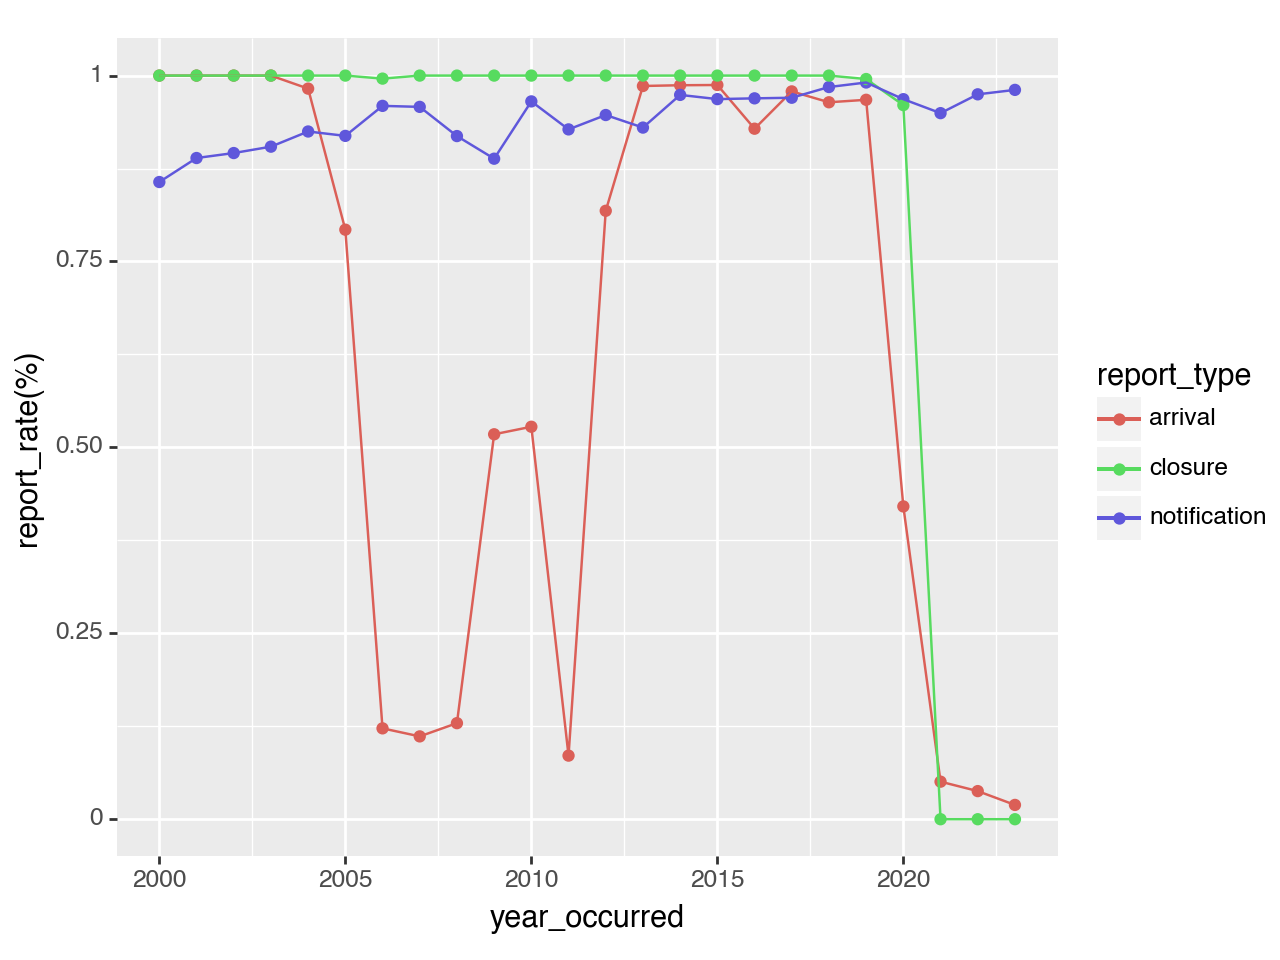

<Figure Size: (640 x 480)>

In [34]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '18', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 19

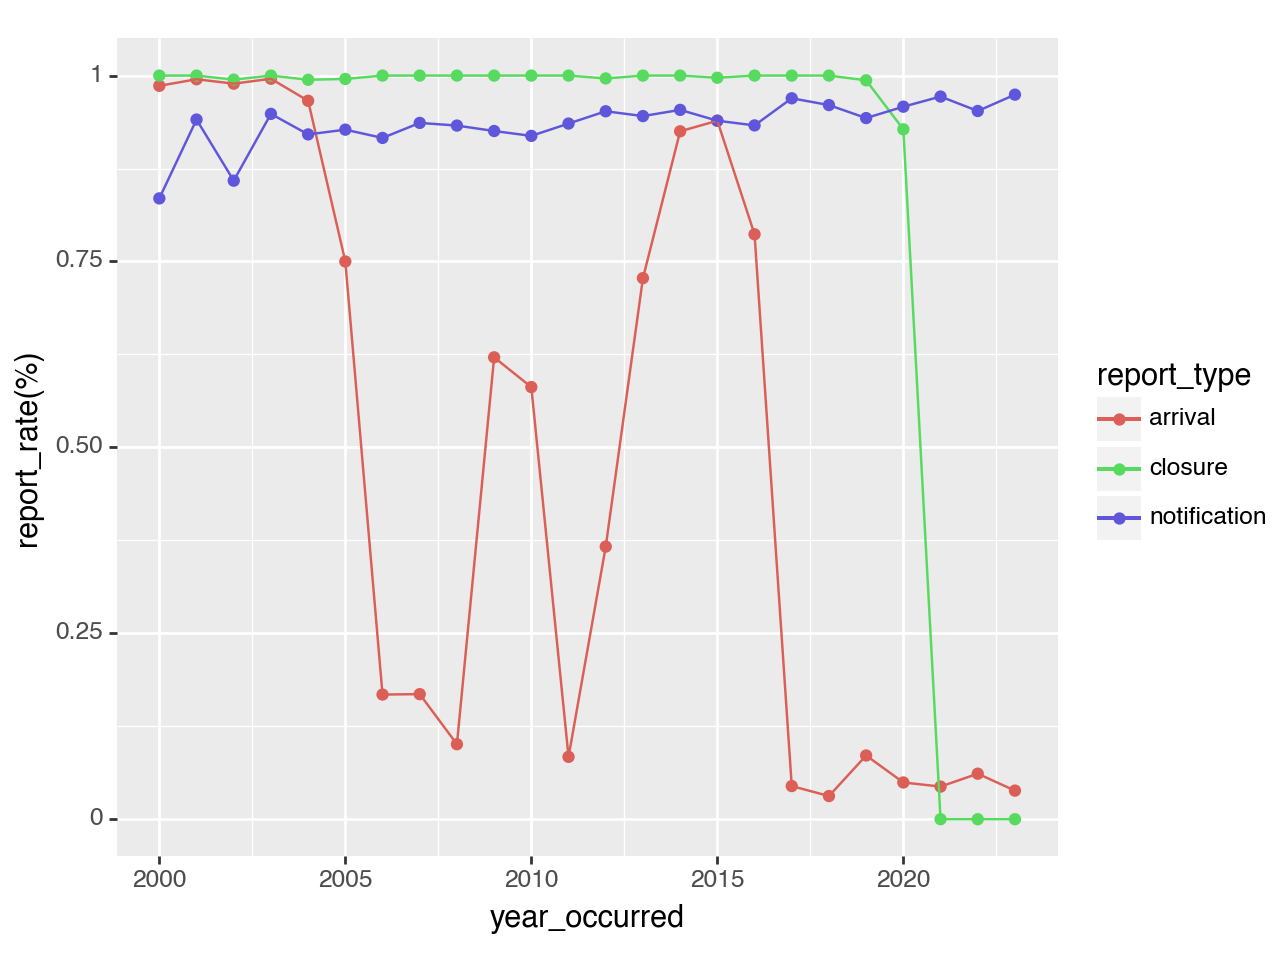

<Figure Size: (640 x 480)>

In [35]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '19', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 20

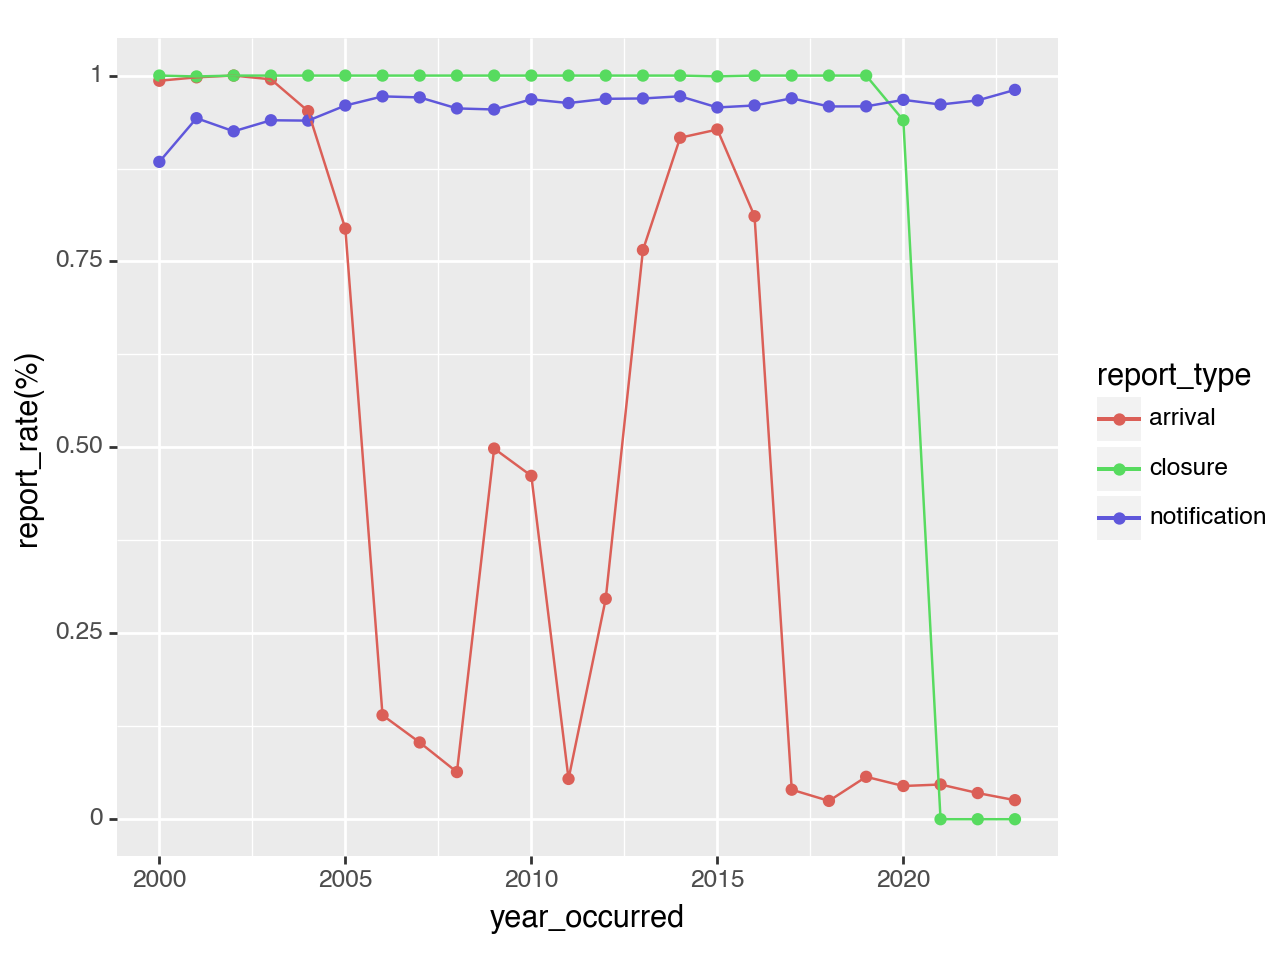

<Figure Size: (640 x 480)>

In [36]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '20', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 21

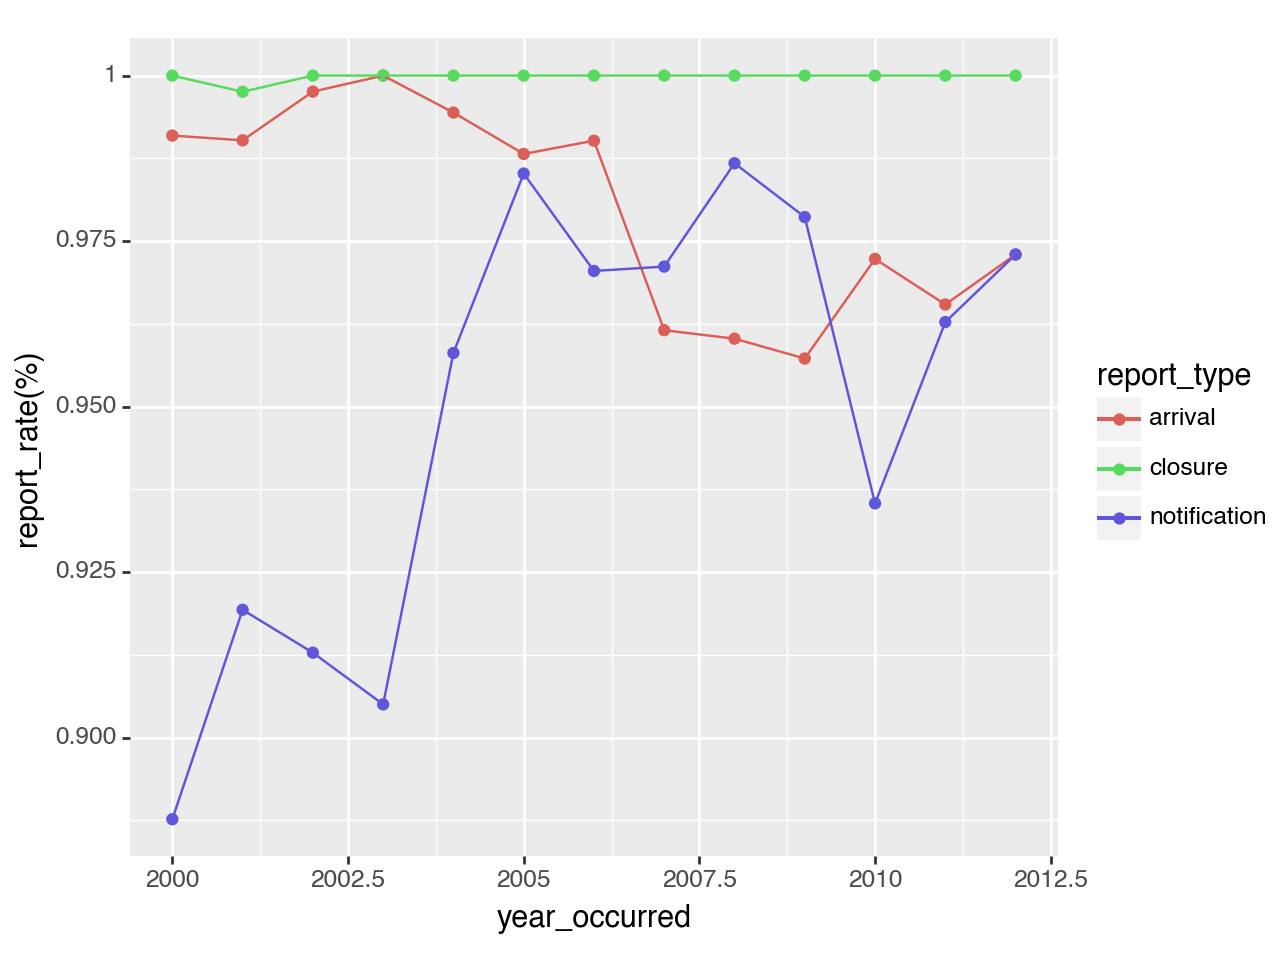

<Figure Size: (640 x 480)>

In [37]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '21', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 22

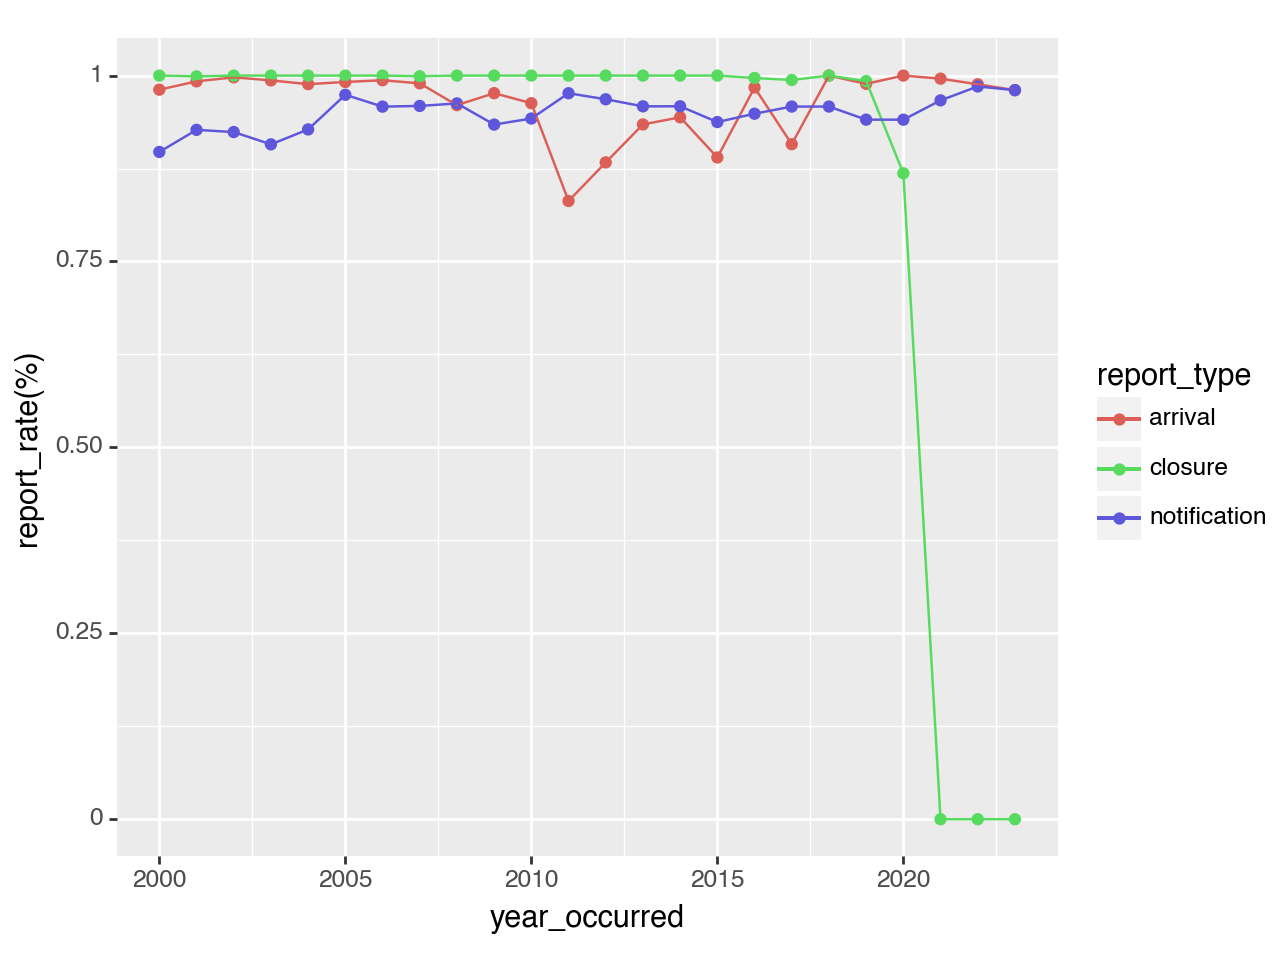

<Figure Size: (640 x 480)>

In [38]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '22', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 23

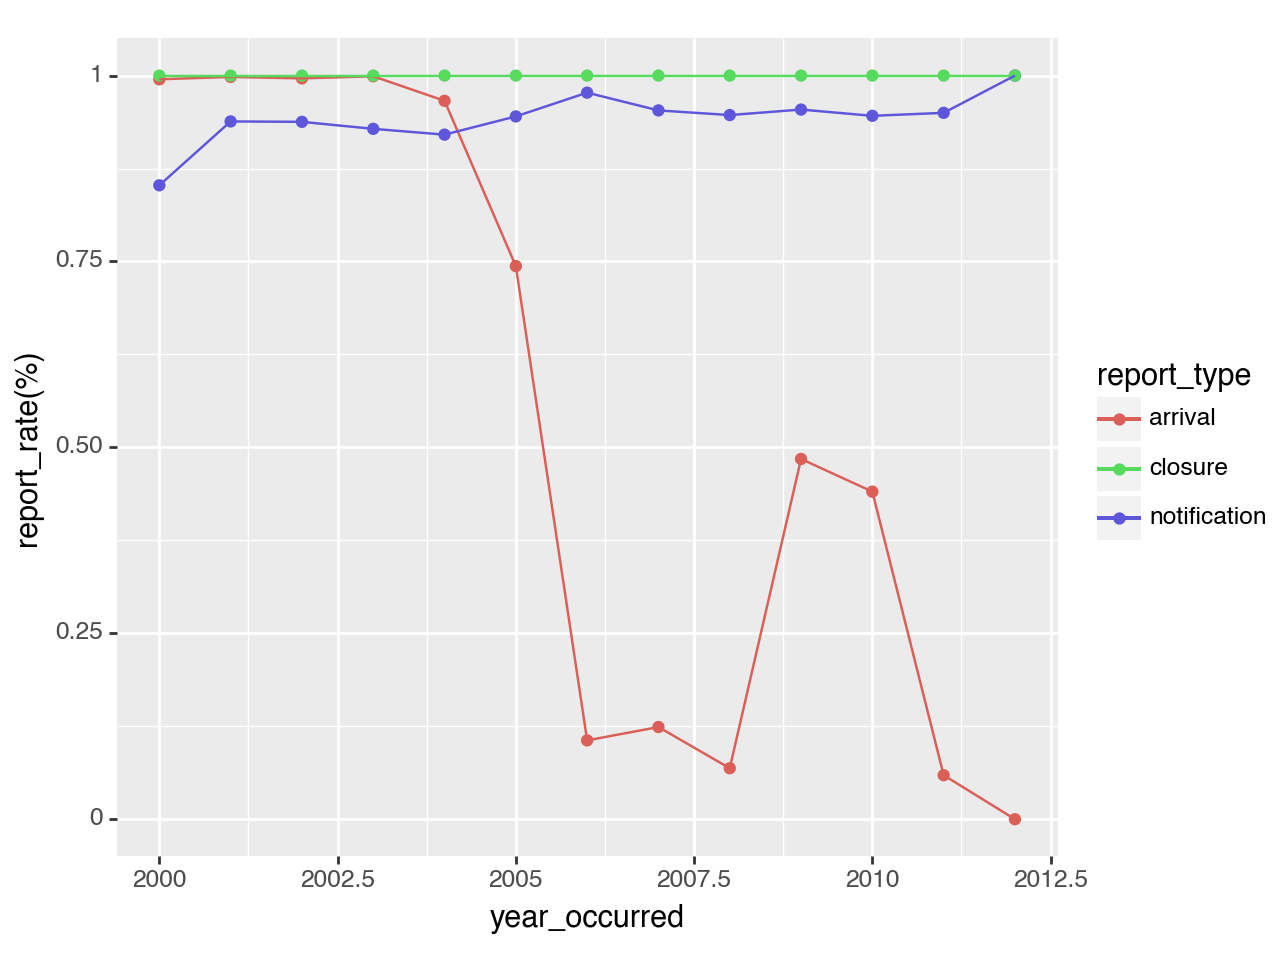

<Figure Size: (640 x 480)>

In [39]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '23', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 24

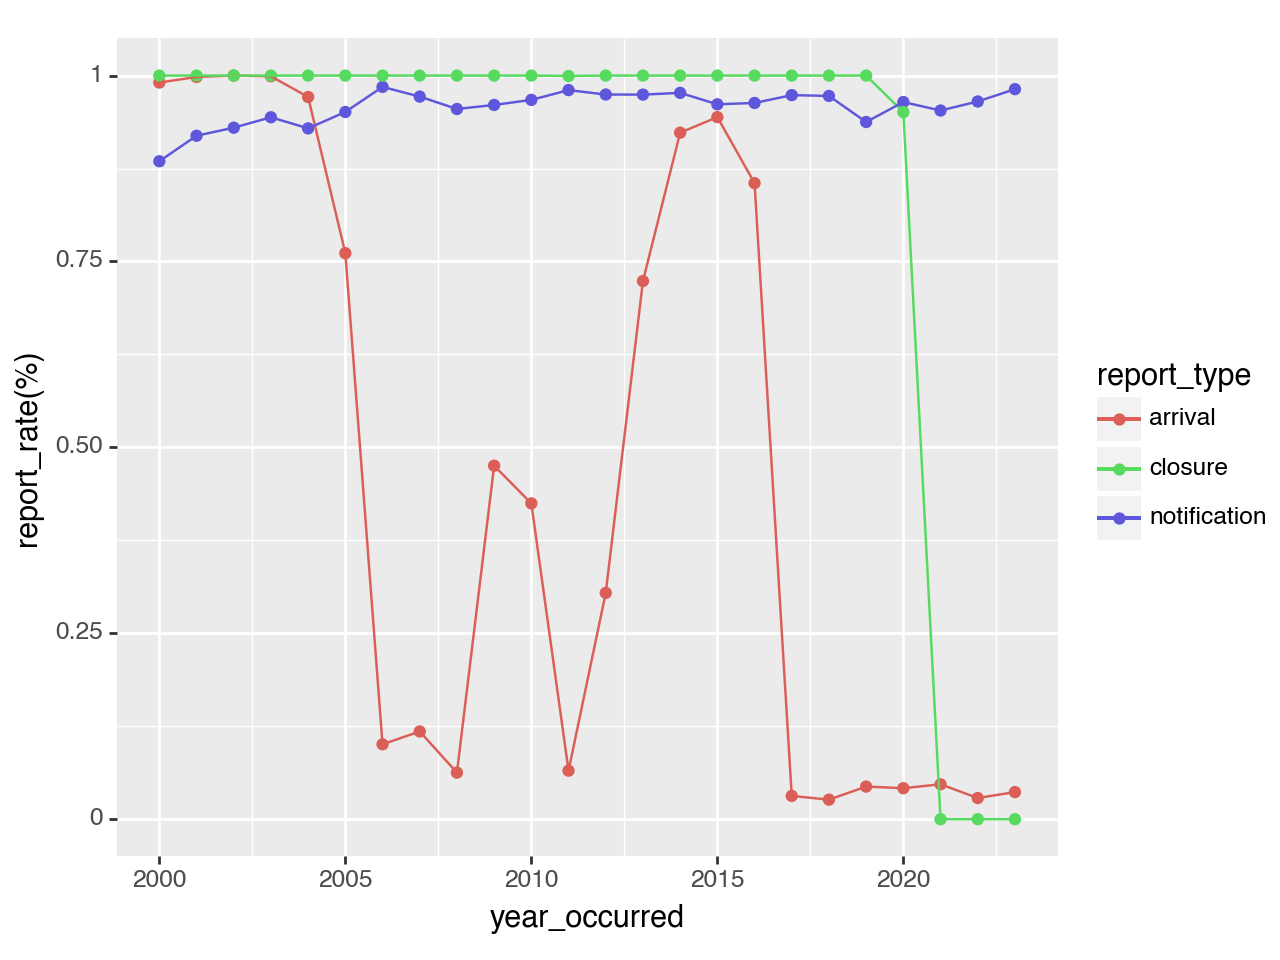

<Figure Size: (640 x 480)>

In [40]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '24', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 25

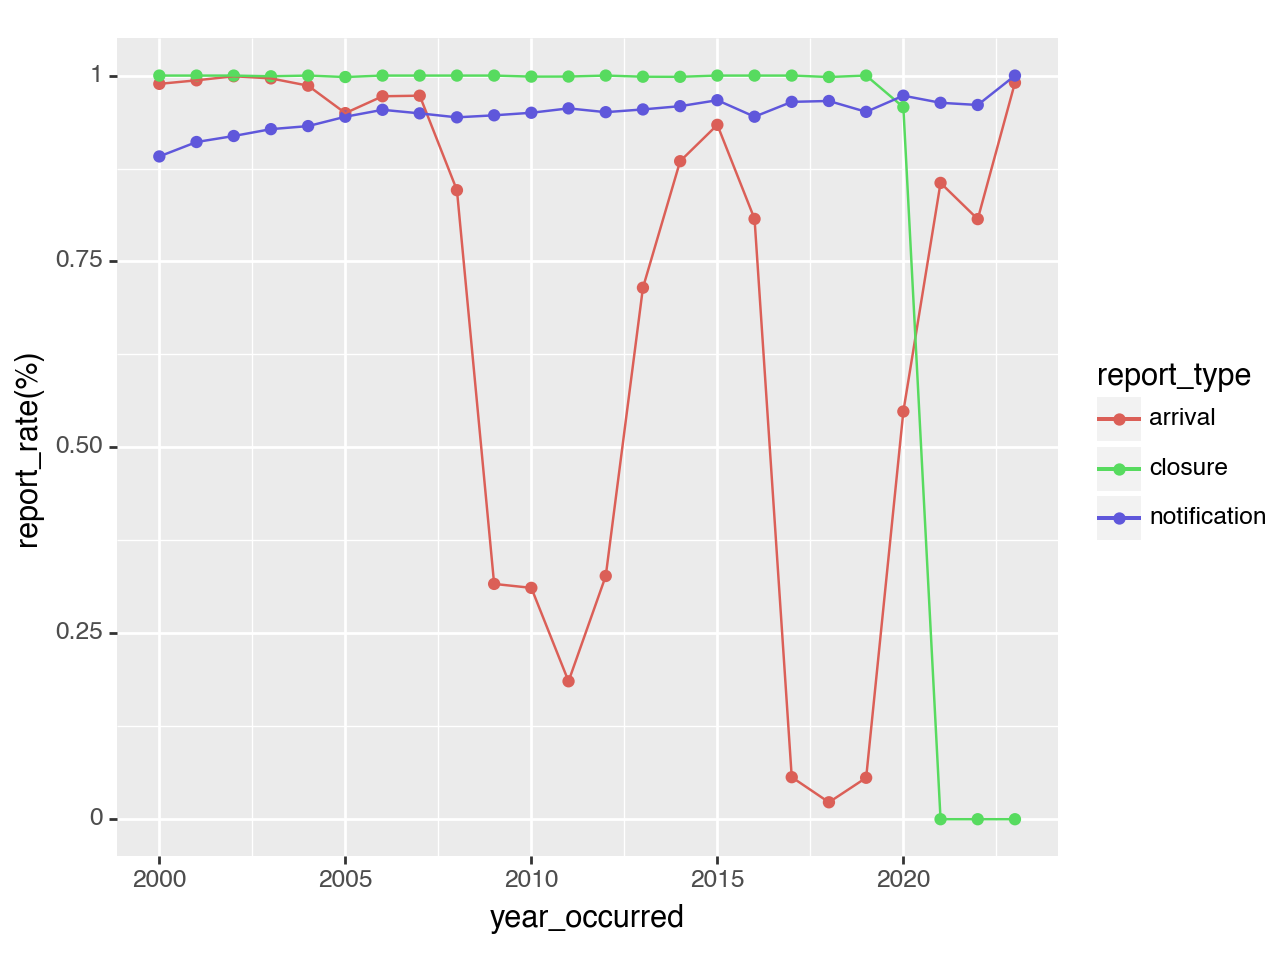

<Figure Size: (640 x 480)>

In [41]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '25', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 31

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:111: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


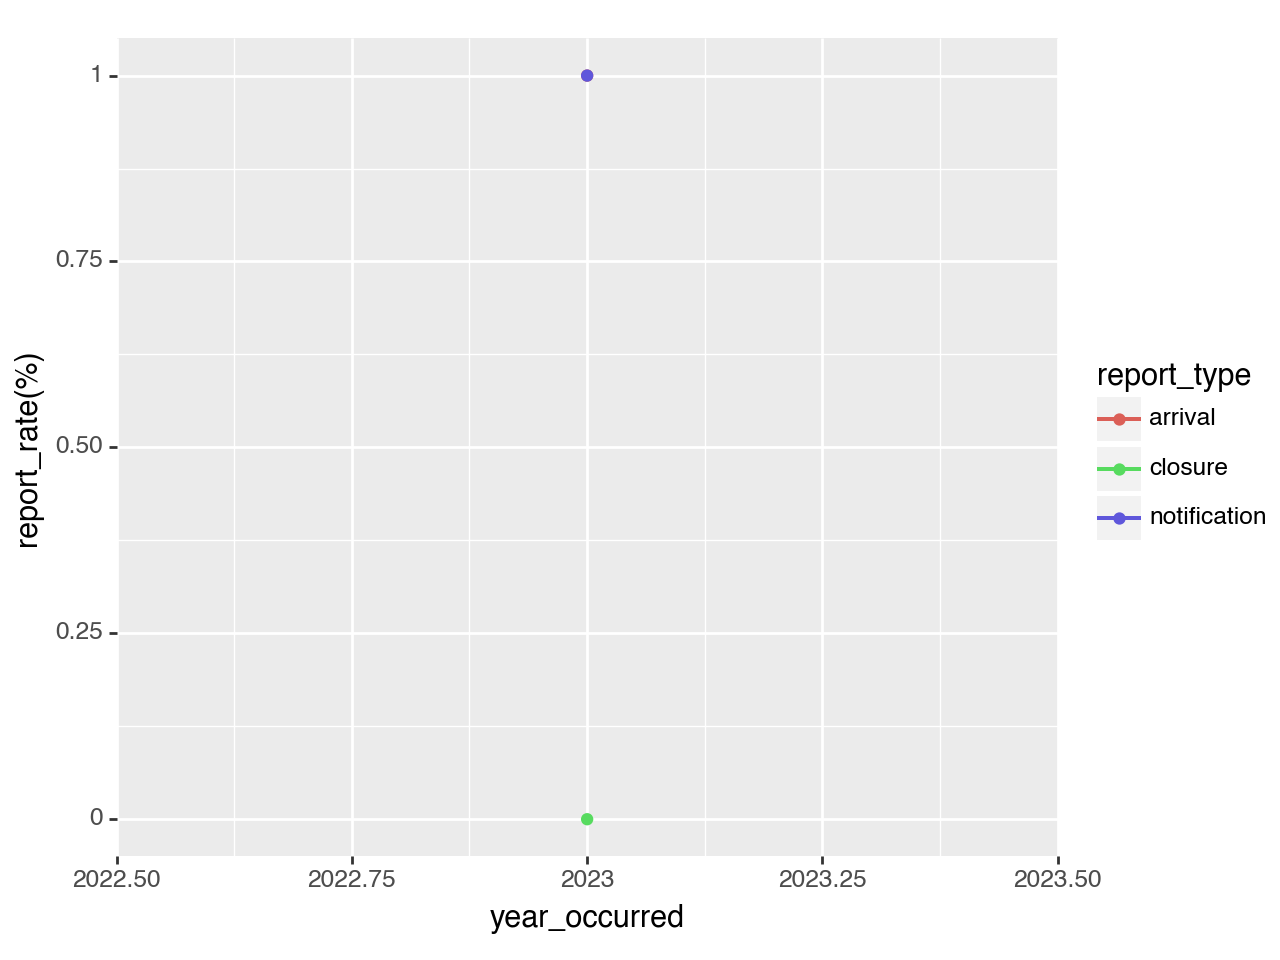

<Figure Size: (640 x 480)>

In [42]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '31', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())